In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # Prediction of Gestational Weight Gain for Pregnancy: A Machine Learning-Based Multiclass Classification Approach.
#
# #### Audencio Victor
#
# ##### Dataset: Coorte-Araraquara
#
# ##### Objetivo da Análise: Identificação precoce de mulheres com maior risco de ganho de peso excessivo durante a gestação pode permitir intervenções precoces para prevenir complicações e promover um ganho de peso adequado

In [ ]:
# ##### O Conjunto de dados possui 1455 observações, com as as seguintes variáveis listadas:

# ### O Conjunto de dados possui 1455 observações, com as as seguintes variáveis listadas:
#  1. a_idade - Idade materna,
#  2. a_estat1 - Altura,
#  3. a_pesopre - peso pregestational,
#  4. a_imcpg - IMC-pregest,
#  5. a_cor -Raca,((1) branca / (2) preta / (3) amarela / (4) indígena / (5) parda)
#  6. a_vigord -Actividade fisica
#  7. a_fumog - Fumar
#  8. a_igadums -Idade gestacional em semanas,
#  9. a_agdm -Diabetes
#  10. a_aghas -Hipertensao
#  11. a_npari- Numero de gravidezes anterior
#  12. a_escola - Escolaridade  da gestante (em anos de estudos)
#  13. a_civil - Estado civil  (1) casada  e solteira (com companheiro) / (2) solteira (sem companheiro) /separada/viúva
#  14. a_hba1c - hemoglobina glicada,
#  15. a_hdl- HDL
#  16. a_ldl-LDL
#  17. a_ct - colestreol
#  18. categoria - Ganho de peso gestacional

# ### Roteiro:
# 1. Importação dos Pacotes
# 2. Chamada do Conjunto de Dados
# 3. Transformação das Variáveis
# 4. Separação em treino e teste - Split aplicado de 70%
# 5. Retirada de variáveis indesejadas
# 6. Correlação/Teste de dependência *_(novo)_*
# 7. Gráficos de frequências para X_train
# 8. One Hot Encoding
# 9. Treinamento do Primeiro Modelo
# 10. Obtenção das métricas com base no conjunto de teste
# 11. Treinando e comparando múltiplos algoritmos
# 12. Desenvolvendo algoritmo selecionado
#     * Logistic Regression
#     * LightGBM
#     * Adaboost
# 13. Feature Selection - Boruta
# 14. Modelos com Boruta
# 15. Shapley
#

In [ ]:
# ####  Instalação dos pacotes
!pip install catboost pycaret lazypredict dfply pyforest boruta scikit-plot graphviz dtreeviz yellowbrick hyperopt -q

In [ ]:
##### Importação dos Pacotes
import warnings  # ignorando os warnings emitidos pelo Python
warnings.filterwarnings("ignore")
import numpy as np  # para processamento numérico de bancos de dados
import pandas as pd  # manipulação de dados
import matplotlib.pyplot as plt  # para geração de gráficos
from matplotlib import rc  # configurações adicionais para os gráficos a serem gerados
from dfply import *  # para importar os comandos da biblioteca dfply
import seaborn as sns  # alternativa para a matplotlib para geração de gráficos
from sklearn.model_selection import train_test_split  # para divisão de dados
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize  # pré-processamento de dados
from sklearn.compose import ColumnTransformer  # para transformações de colunas
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve,matthews_corrcoef, classification_report,
                             confusion_matrix, precision_recall_curve, auc)  # métricas de avaliação
from imblearn.over_sampling import SMOTE  # para oversampling
from boruta import BorutaPy  # para seleção de características
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier  # classificadores
from xgboost import XGBClassifier  # XGBoost
from lightgbm import LGBMClassifier  # LightGBM
from catboost import CatBoostClassifier  # CatBoost
from lightgbm import LGBMClassifier # Light GBM
from sklearn.linear_model import LogisticRegression  # Regressão Logística
from tabpfn import TabPFNClassifier  # TabPFN
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK  # para otimização de hiperparâmetros
from hyperopt.pyll.base import scope  # suporte para o Hyperopt

# Configurações adicionais para os gráficos a serem gerados
get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use("fivethirtyeight")
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina' # formato das imagens")
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})  # fonte utilizada
rc('mathtext',**{'default':'regular'})

# Definir a semente de aleatoriedade
np.random.seed(45)

In [ ]:
#### Importação dos dados
data = pd.read_csv("DadosML (1).csv")
data.head()

,a_idade,a_estat1,b_estat1,a_pesoat,b_pesoat,a_pesopre,a_rendpcr,a_civil,a_escola,a_hb,...,a_hdl,b_ct,d_InPond,d_perintg,d_IntercRN,d_IGUSGrn,a_npar,imc,gpg,categoria
0,3,165.0,165.2,70.2,72.80,70.2,550.000000,2,1.0,12.3,...,38.0,198.0,2.72,NaN,0.0,270.0,NaN,25.785124,2.8,Abaixo
1,1,163.5,163.5,46.4,51.50,46.4,825.000000,1,1.0,13.3,...,42.0,219.0,2.46,NaN,0.0,268.0,NaN,17.357312,28.6,Acima
2,2,180.0,181.0,61.9,65.60,61.9,693.333333,2,1.0,11.7,...,46.0,161.0,2.38,NaN,0.0,284.0,NaN,19.104938,10.8,Abaixo
3,2,161.5,161.5,82.0,90.40,82.0,1200.000000,2,2.0,13.0,...,51.0,225.0,2.99,NaN,0.0,256.0,NaN,31.439005,15.5,Acima
4,2,167.0,166.8,70.0,73.05,70.0,734.000000,2,1.0,11.5,...,59.0,184.0,2.80,NaN,0.0,280.0,NaN,25.099502,13.3,Acima


In [ ]:
# #### Transformação das Variáveis
# O IOM (Institute of Medicine) publicou em 2009 e atualizou em 2019 suas recomendações para o ganho de peso durante a gestação com base no índice de massa corporal (IMC) pré-gestacional da mulher. Essas recomendações são baseadas em evidências e foram desenvolvidas para promover a saúde materna e fetal, reduzindo riscos à saúde associados ao ganho excessivo ou insuficiente de peso durante a gestação.
#
# A classificação do ganho de peso gestacional segundo o IOM 2019, baseada no IMC pré-gestacional da mulher, é a seguinte:
#
# IMC < 18,5 (baixo peso):
# Ganho de peso recomendado: 12,5 a 18 kg.
# IMC entre 18,5 e 24,9 (peso normal):
#
# Ganho de peso recomendado: 11,5 a 16 kg.
# IMC entre 25 e 29,9 (sobrepeso):
#
# Ganho de peso recomendado: 7 a 11,5 kg.
# IMC entre 30 e 34,9 (obesidade grau 1):
#
# Ganho de peso recomendado: 5 a 9 kg.
# IMC entre 35 e 39,9 (obesidade grau 2):
#
# Ganho de peso recomendado: 4 a 7 kg.
# IMC ≥ 40 (obesidade grau 3):
#
# Ganho de peso recomendado: 3 a 6 kg.
# É importante lembrar que essas recomendações são gerais e podem ser ajustadas de acordo com a situação individual de cada mulher, devendo sempre ser acompanhadas pelo médico obstetra.
# ###### Para este estudo teremoos  3 categorias: Abaixo, acima e dentro das recomendacoes.

In [ ]:
# Instantiate a LabelEncoder object
le = LabelEncoder()

data['categoria'] = le.fit_transform(data['categoria'])
data['categoria']

columns_to_remove = ['d_InPond', 'd_perintg', 'd_IntercRN', 'd_IGUSGrn', 'a_npar', 'd_PesoParto', 'gpg']
data = data.drop(columns=columns_to_remove, errors='ignore')

In [ ]:
# ### Gerar a matriz de correlação
# Gerar a matriz de correlação
# correlation_matrix = data.corr()

# Exibir a matriz de correlação
# print(correlation_matrix)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Ajustar o tamanho da figura
# plt.figure(figsize=(20, 15))

# # Plotar o mapa de calor da matriz de correlação com ajustes
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
#             annot_kws={"size": 7}, cbar_kws={"shrink": .8}, linewidths=0.5, linecolor='gray')

# # Ajustar os labels dos eixos
# plt.xticks(rotation=45, ha='right', fontsize=12)
# plt.yticks(fontsize=12)

# # Título do mapa de calor
# plt.title('Matriz de Correlação', fontsize=20)

# # Mostrar o mapa de calor
# plt.show()

In [ ]:
# print(data.isnull().sum())

# Verificar os tipos de dados e valores ausentes
# data.info()

# Transformação das variáveis categóricas
columns_to_category = [
    'a_cor', 'a_civil', 'a_vigord', 'a_moderd', 'a_fumog', 'a_agdm', 'a_aghas',
    'b_vigord', 'b_moderd', 'b_fumog', 'a_alcool', 'b_alcool', 'b_agdm', 'b_aghas'
]
# Loop para transformar cada coluna em categórico
for column in columns_to_category:
    data[column] = data[column].astype('category')

In [ ]:
# One Hot Encoding das variáveis categóricas
categorical_features = ['a_cor', 'a_civil', 'a_vigord', 'a_moderd', 'a_fumog', 'a_agdm', 'a_aghas',
                       'b_vigord', 'b_moderd', 'b_fumog', 'a_alcool','b_alcool','b_agdm', 'b_aghas']

In [ ]:
# Remover colunas com apenas 2 categorias da lista de features a serem dummificadas
categorical_features = [col for col in categorical_features if data[col].nunique() > 2]

# Aplicar One Hot Encoding apenas nas colunas com mais de 2 valores únicos
data = pd.get_dummies(data, columns=categorical_features)

In [ ]:
numeric_cols = data.select_dtypes(include=[np.number]).columns

In [ ]:
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

In [ ]:
data['categoria'].value_counts()

categoria
1    604
0    506
2    447
Name: count, dtype: int64

In [ ]:
### Separação entre treino e teste

# Separação em treino e teste - Split aplicado de 70%
X = data.drop(columns=['categoria'])
y = data['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_test.columns
# X_train.columns

In [ ]:
# Removendo colunas desnecessárias
# colunas_para_remover = ['a_fumog_0', 'a_fumog_1', 'a_agdm_0', 'a_agdm_1', 'a_aghas_0', 'a_aghas_1',
#                         'b_fumog_0.0', 'b_fumog_1.0', 'a_alcool_0', 'a_alcool_1', 'b_alcool_0.0',
#                         'b_alcool_1.0', 'b_agdm_0.0', 'b_agdm_1.0', 'b_aghas_0.0', 'b_aghas_1.0']

# Selecionando colunas para treino e teste, excluindo as colunas indesejadas
colunas_selecionadas = [
    'a_idade', 'a_estat1', 'b_estat1', 'a_pesoat', 'b_pesoat', 'a_pesopre', 'a_rendpcr',
    'a_escola', 'a_hb', 'b_hb', 'a_npari', 'a_npcomo',
    'a_imcpg', 'a_imcga',
    'b_imcga',
    'a_fmp', 'b_fmp', 'b_hba1c', 'b_hdl', 'a_ldl', 'a_ct', 'a_pcr', 'b_pcr', 'a_circbracm',
    'b_circbracm', 'a_igadums', 'a_hba1c', 'a_hdl', 'b_ct',
#     'imc',
    'a_cor_1', 'a_cor_2',
    'a_cor_3', 'a_cor_4', 'a_cor_5', 'a_civil_1', 'a_civil_2', 'a_civil_3', 'a_civil_4',
    'a_vigord_0', 'a_vigord_1', 'a_vigord_2', 'a_vigord_3', 'a_vigord_4', 'a_vigord_5',
    'a_vigord_6', 'a_vigord_7', 'a_moderd_0', 'a_moderd_1', 'a_moderd_2', 'a_moderd_3',
    'a_moderd_4', 'a_moderd_5', 'a_moderd_6', 'a_moderd_7',
    # 'a_fumog_0', 'a_fumog_1', 'a_agdm_0', 'a_agdm_1', 'a_aghas_0', 'a_aghas_1',
    'b_vigord_0.0', 'b_vigord_1.0', 'b_vigord_2.0', 'b_vigord_3.0', 'b_vigord_4.0',
    'b_vigord_5.0', 'b_vigord_6.0', 'b_vigord_7.0', 'b_moderd_0.0', 'b_moderd_1.0',
    'b_moderd_2.0', 'b_moderd_3.0', 'b_moderd_4.0', 'b_moderd_5.0', 'b_moderd_6.0',
    'b_moderd_7.0',
    # 'b_fumog_0.0', 'b_fumog_1.0', 'a_alcool_0', 'a_alcool_1', 'b_alcool_0.0',
    # 'b_alcool_1.0', 'b_agdm_0.0', 'b_agdm_1.0', 'b_aghas_0.0', 'b_aghas_1.0'
]

# Aplicando a seleção de colunas ao conjunto de treino e teste
X_train = X_train.loc[:, colunas_selecionadas]
X_test = X_test.loc[:, colunas_selecionadas]

# Exibindo as primeiras linhas para verificação
# X_train.head(), X_test.head()

In [ ]:
# X_train

In [ ]:
X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [ ]:
### Variáveis contínuas que serão padronizadas
continuous_cols = ['a_idade', 'a_estat1', 'b_estat1', 'a_pesoat', 'b_pesoat', 'a_pesopre',
       'a_rendpcr','a_escola', 'a_hb', 'b_hb',
       'a_npari', 'a_npcomo', 'a_imcpg', 'a_imcga', 'b_imcga', 'a_fmp',
       'b_fmp', 'b_hba1c', 'b_hdl', 'a_ldl', 'a_ct', 'a_pcr', 'b_pcr',
       'a_circbracm', 'b_circbracm', 'a_igadums', 'a_hba1c', 'a_hdl', 'b_ct']

def setScaler():
  ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough' # Utilizamos para manter as colunas em que não aplicamos o scaler
  )
  return ct

In [ ]:
scaler = setScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# para evitarmos a exibição dos dados em notacao científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_test_columns)

In [ ]:
# Aplicação do SMOTE para balanceamento das classes
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix

def calculate_metrics(y_true, y_pred, y_pred_proba, class_label):
    # Transformar o problema em "one vs all"
    y_true_bin = (y_true == class_label).astype(int)
    y_pred_bin = (y_pred == class_label).astype(int)

    if y_pred_proba.ndim > 1:
        y_pred_proba_bin = y_pred_proba[:, class_label]
    else:
        y_pred_proba_bin = y_pred_proba

    # Calcular a acurácia
    accuracy = accuracy_score(y_true_bin, y_pred_bin)

    # Calcular AUC-ROC
    if len(np.unique(y_true_bin)) > 1:  # Check if both classes are present
        auc_roc = roc_auc_score(y_true_bin, y_pred_proba_bin)
    else:
        auc_roc = None

    # Calcular Recall
    recall = recall_score(y_true_bin, y_pred_bin)

    # Calcular Precisão
    precision = precision_score(y_true_bin, y_pred_bin)

    # Calcular F1 Score
    f1 = f1_score(y_true_bin, y_pred_bin)

    # Calcular MCC
    mcc = matthews_corrcoef(y_true_bin, y_pred_bin)

    # Calcular Especificidade
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()
    specificity = tn / (tn + fp)

    return {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'MCC': mcc
    }

In [ ]:
# Inicializar um DataFrame para armazenar as métricas
metrics_df = pd.DataFrame(columns=['Model', 'Class', 'Accuracy', 'AUC-ROC', 'Recall', 'Specificity', 'Precision', 'F1', 'MCC'])

In [ ]:
# Lista de modelos e seus nomes
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('CatBoost', CatBoostClassifier(verbose=0)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
]

# Inicializar dicionários para armazenar as probabilidades e as previsões
model_probs = {}
model_preds = {}

In [ ]:
# Loop para treinar os modelos e calcular as métricas
for model_name, model in models:
    print(f"Training {model_name}...")
    # Treinamento do modelo
    model.fit(X_train, y_train)

    # Previsão e obtenção das probabilidades
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Salvar as previsões e as probabilidades
    model_preds[model_name] = y_pred
    model_probs[model_name] = y_pred_proba

    # Calcular e salvar as métricas para cada classe
    for class_label in np.unique(y_train):
        metrics = calculate_metrics(y_test, y_pred, y_pred_proba, class_label)

        # Adicionar as métricas ao DataFrame
        new_row = pd.DataFrame({
            'Model': [f"{model_name} (Class {class_label})"],
            'Class': [class_label],
            'Accuracy': [metrics['Accuracy']],
            'AUC-ROC': [metrics['AUC-ROC']],
            'Recall': [metrics['Recall']],
            'Specificity': [metrics['Specificity']],
            'Precision': [metrics['Precision']],
            'F1': [metrics['F1']],
            'MCC': [metrics['MCC']]
        })
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Exibir as métricas
print(metrics_df)

Training Logistic Regression...
Training Random Forest...
Training LightGBM...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 1089, number of used features: 59
[LightGBM] [Info] Start training from score -1.118084
[LightGBM] [Info] Start training from score -0.950382
[LightGBM] [Info] Start training from score -1.250012
Training AdaBoost...
Training CatBoost...
Training XGBoost...
                            Model Class  Accuracy  AUC-ROC  Recall  \
0   Logistic Regression (Class 0)     0      0.71     0.77    0.62   
1   Logistic Regression (Class 1)     1      0.68     0.74    0.66   
2   Logistic Regression (Class 2)     2      0.67     0.55    0.25   
3         Random Forest (Class 0)     0      0.73     0.75    0.53   
4         Random Forest (Class 1)     1      0.68     0.

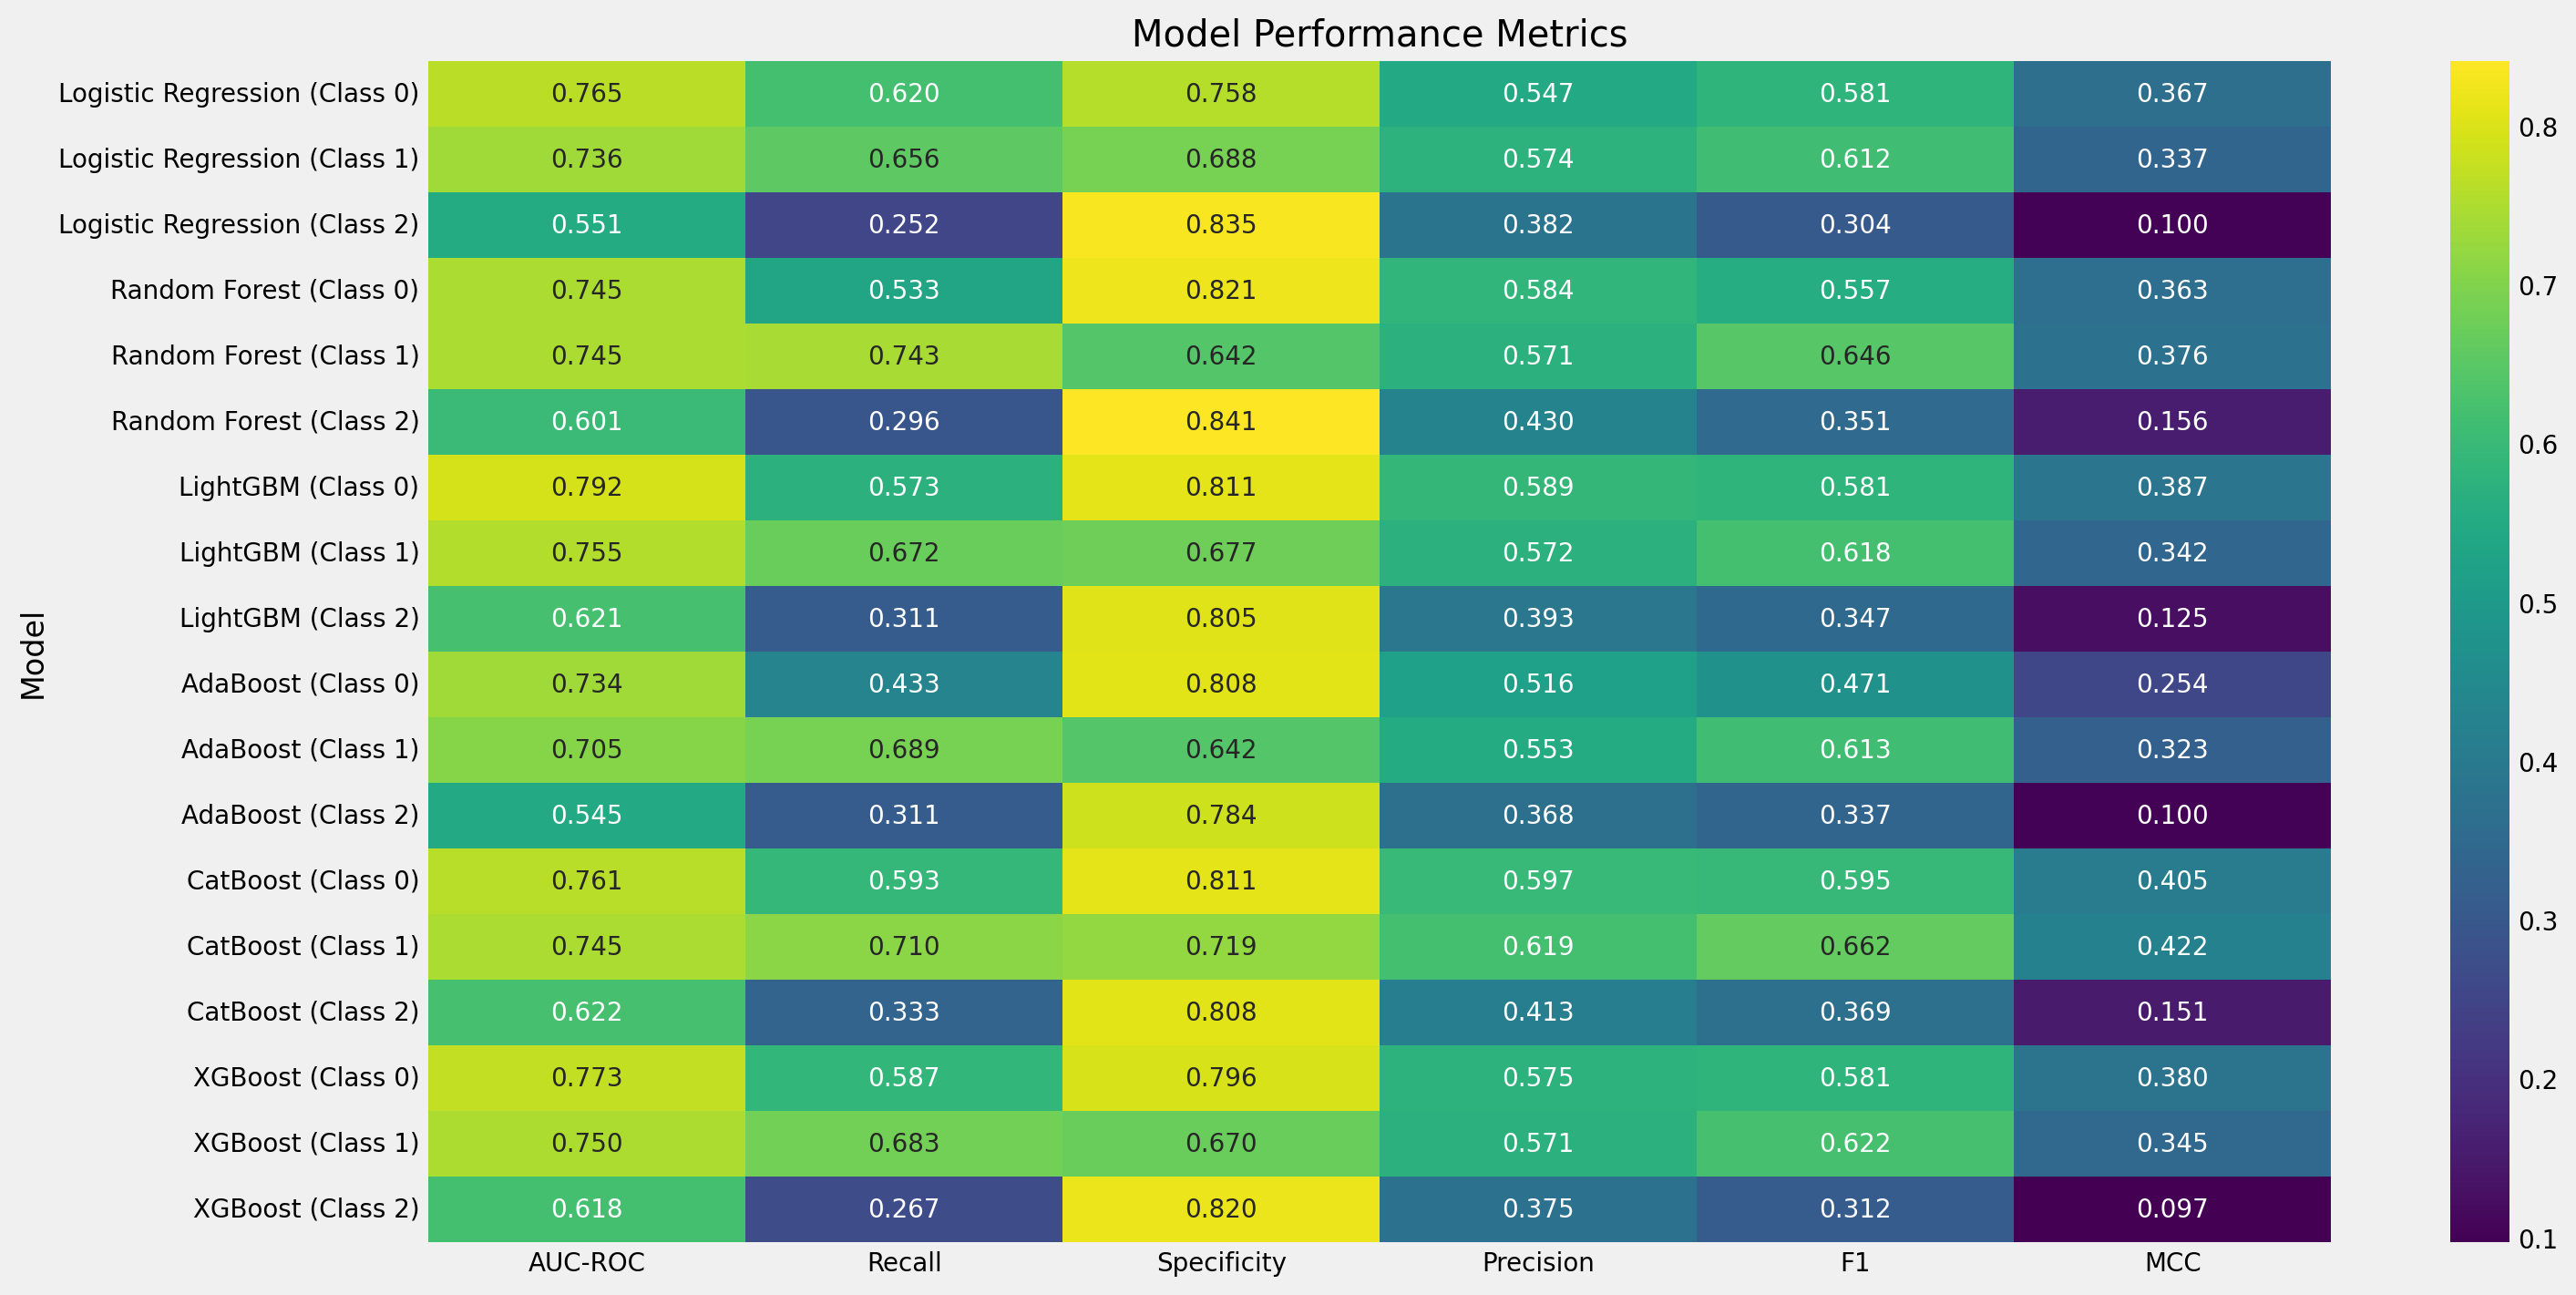

In [ ]:
# Visualizar as métricas como um heatmap (removendo a coluna 'Class')
plt.figure(figsize=(15, 8))
sns.heatmap(metrics_df.set_index('Model').iloc[:, 2:], annot=True, cmap='viridis', cbar=True, fmt='.3f')
plt.title('Model Performance Metrics')
plt.show()

                            Model Class  Accuracy  AUC-ROC  Recall  \
6              LightGBM (Class 0)     0      0.74     0.79    0.57   
15              XGBoost (Class 0)     0      0.73     0.77    0.59   
0   Logistic Regression (Class 0)     0      0.71     0.77    0.62   
12             CatBoost (Class 0)     0      0.74     0.76    0.59   
7              LightGBM (Class 1)     1      0.68     0.75    0.67   
16              XGBoost (Class 1)     1      0.68     0.75    0.68   
3         Random Forest (Class 0)     0      0.73     0.75    0.53   
13             CatBoost (Class 1)     1      0.72     0.75    0.71   
4         Random Forest (Class 1)     1      0.68     0.75    0.74   
1   Logistic Regression (Class 1)     1      0.68     0.74    0.66   
9              AdaBoost (Class 0)     0      0.69     0.73    0.43   
10             AdaBoost (Class 1)     1      0.66     0.70    0.69   
14             CatBoost (Class 2)     2      0.67     0.62    0.33   
8              Light

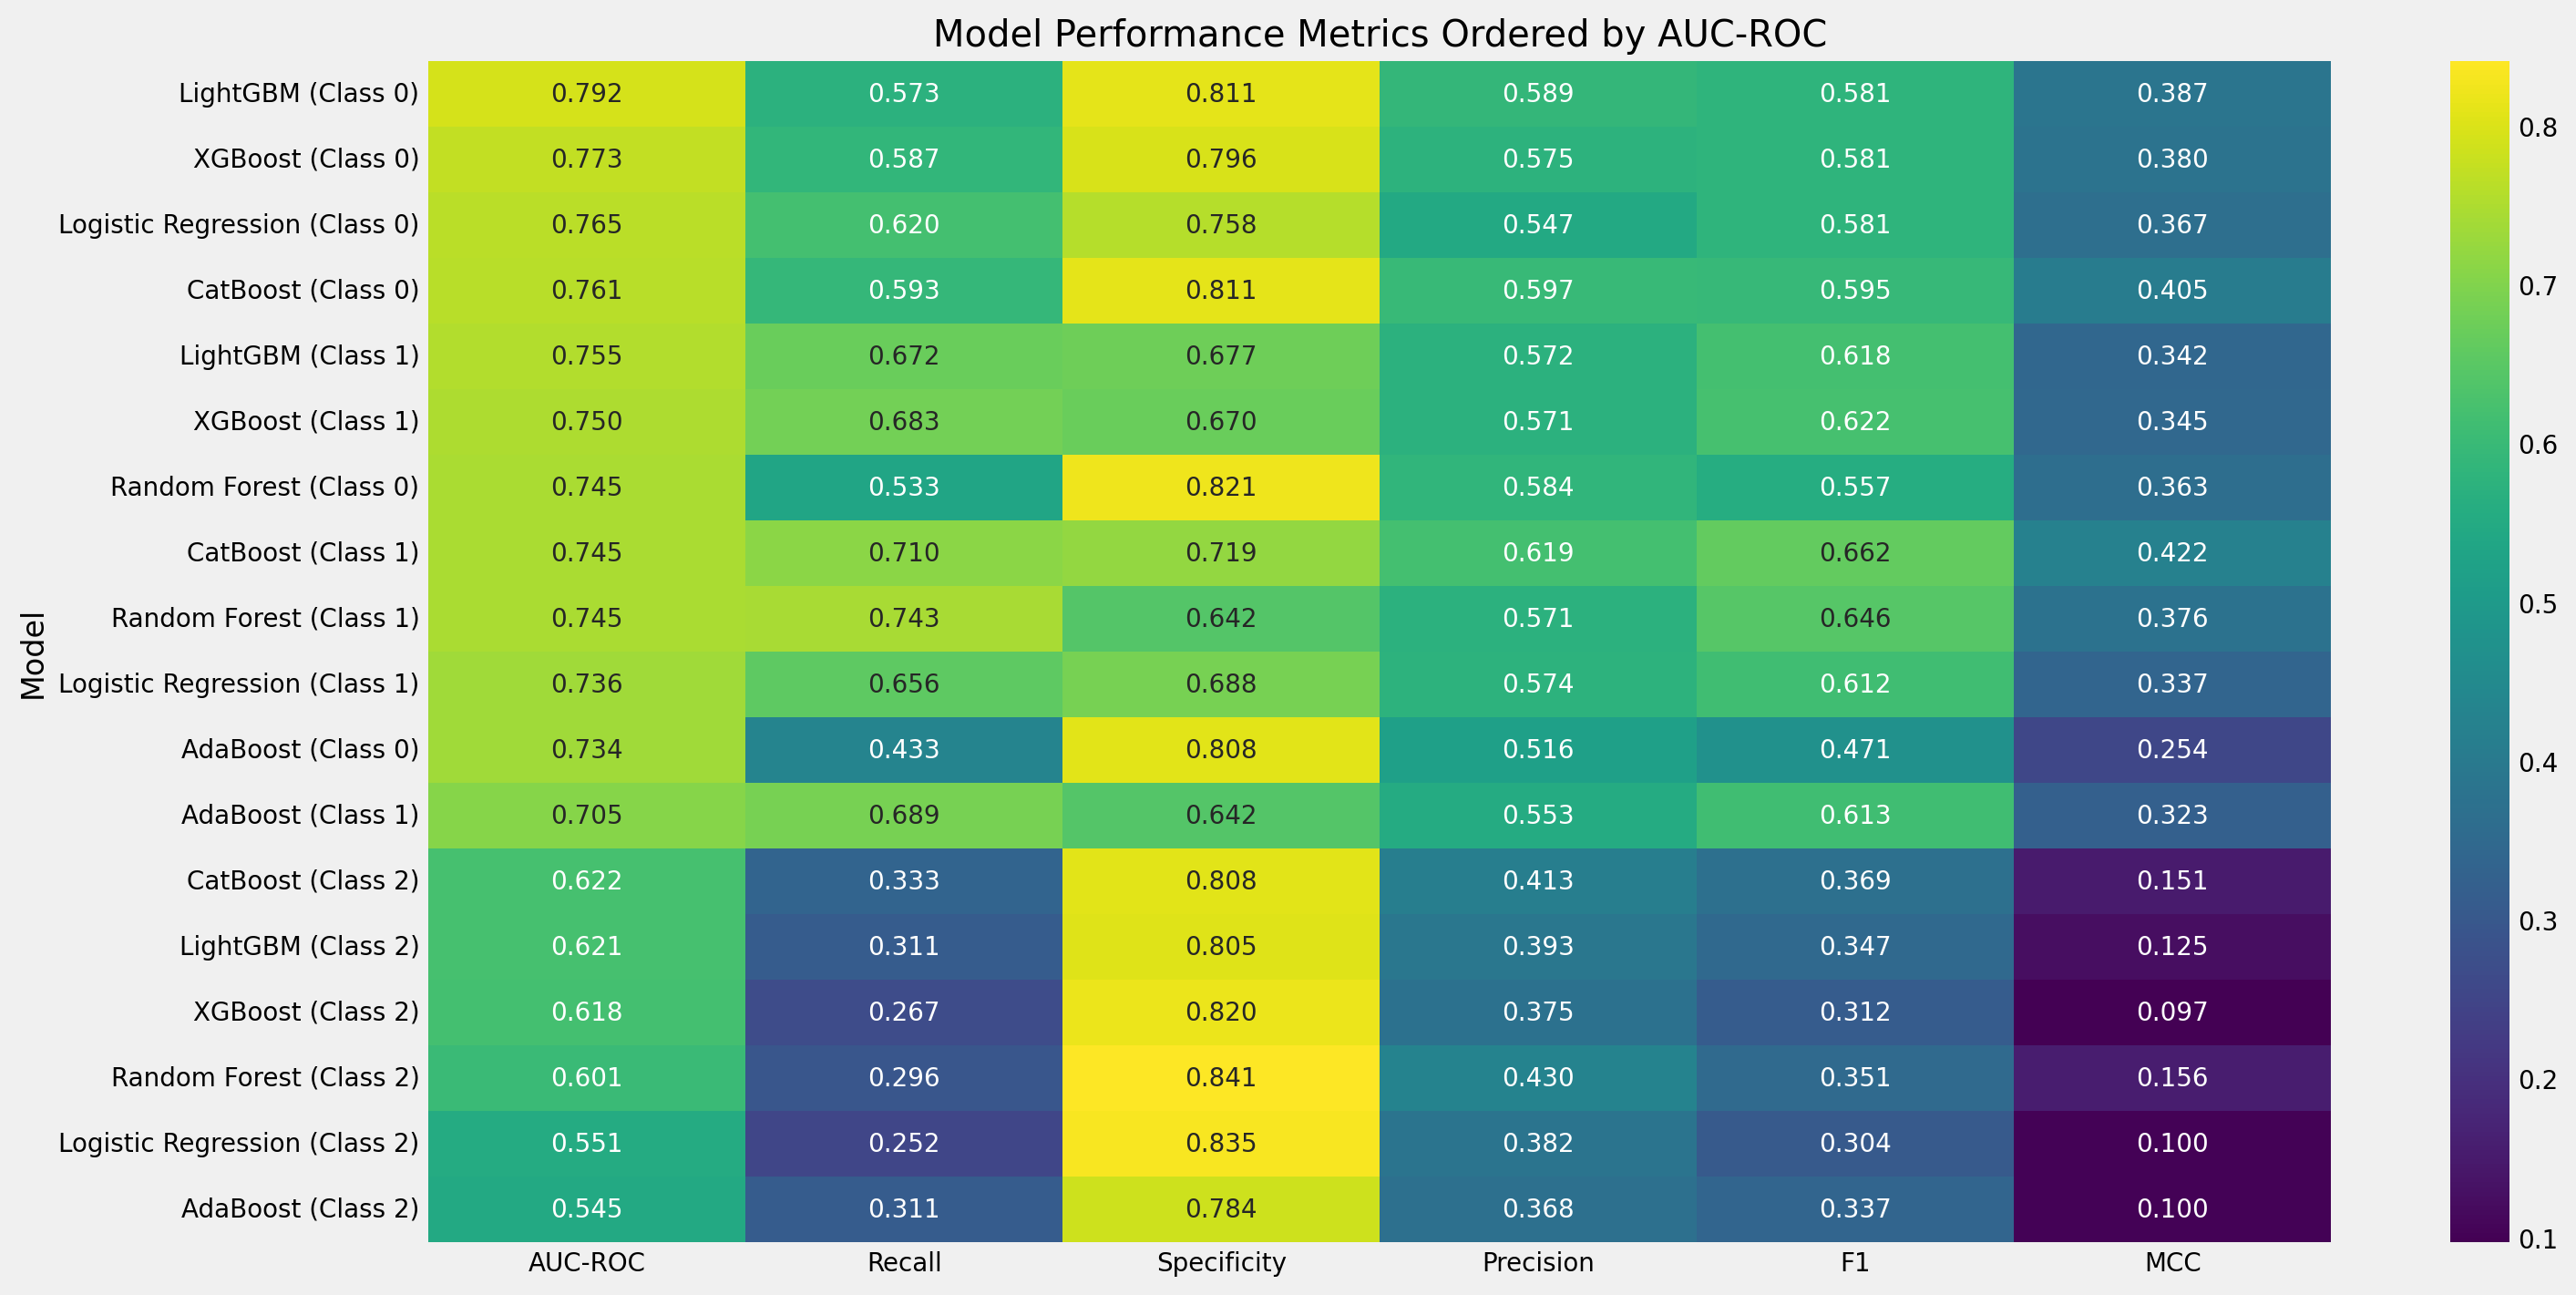

In [ ]:
# Ordenar o DataFrame pela métrica 'AUC-ROC' em ordem decrescente
metrics_df = metrics_df.sort_values(by='AUC-ROC', ascending=False)

# Exibir as métricas
print(metrics_df)

# Visualizar as métricas como um heatmap (removendo a coluna 'Class')
plt.figure(figsize=(15, 8))
sns.heatmap(metrics_df.set_index('Model').iloc[:, 2:], annot=True, cmap='viridis', cbar=True, fmt='.3f')
plt.title('Model Performance Metrics Ordered by AUC-ROC')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir os hiperparâmetros para cada modelo
param_distributions = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'LightGBM': {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.001, 0.01, 0.1],
        'n_estimators': [50, 100, 200]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1]
    },
    'CatBoost': {
        'depth': [4, 6, 8],
        'learning_rate': [0.001, 0.01, 0.1],
        'iterations': [100, 200, 300]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [3, 6, 9]
    }
}

# Lista de modelos e seus nomes
models = {
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}


In [ ]:
# Inicializar um DataFrame para armazenar as métricas
metrics_df = pd.DataFrame(columns=['Model', 'Class', 'Accuracy', 'AUC-ROC', 'Recall', 'Specificity', 'Precision', 'F1', 'MCC'])

# Loop para hiperparametrizar, treinar os modelos e calcular as métricas
for model_name, model in models.items():
    print(f"Hyperparameter tuning and training {model_name}...")

    # Definir a busca aleatória com RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions[model_name],
                                       n_iter=50, scoring='roc_auc_ovr', cv=3, verbose=1, n_jobs=-1, random_state=42)

    # Realizar a busca de hiperparâmetros
    random_search.fit(X_train, y_train)

    # Melhor modelo encontrado
    best_model = random_search.best_estimator_

    # Previsão e obtenção das probabilidades
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)

    # Calcular e salvar as métricas para cada classe
    for class_label in np.unique(y_train):
        metrics = calculate_metrics(y_test, y_pred, y_pred_proba, class_label)

        # Adicionar as métricas ao DataFrame
        new_row = pd.DataFrame({
            'Model': [f"{model_name} (Class {class_label})"],
            'Class': [class_label],
            'Accuracy': [metrics['Accuracy']],
            'AUC-ROC': [metrics['AUC-ROC']],
            'Recall': [metrics['Recall']],
            'Specificity': [metrics['Specificity']],
            'Precision': [metrics['Precision']],
            'F1': [metrics['F1']],
            'MCC': [metrics['MCC']]
        })
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Ordenar o DataFrame pela métrica 'AUC-ROC' em ordem decrescente
metrics_df = metrics_df.sort_values(by='AUC-ROC', ascending=False)

# Exibir as métricas
print(metrics_df)

Hyperparameter tuning and training Random Forest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Hyperparameter tuning and training LightGBM...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 1089, number of used features: 59
[LightGBM] [Info] Start training from score -1.118084
[LightGBM] [Info] Start training from score -0.950382
[LightGBM] [Info] Start training from score -1.250012
Hyperparameter tuning and training AdaBoost...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Hyperparameter tuning and training CatBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Hyperparameter tuning and training XGBoost...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
   

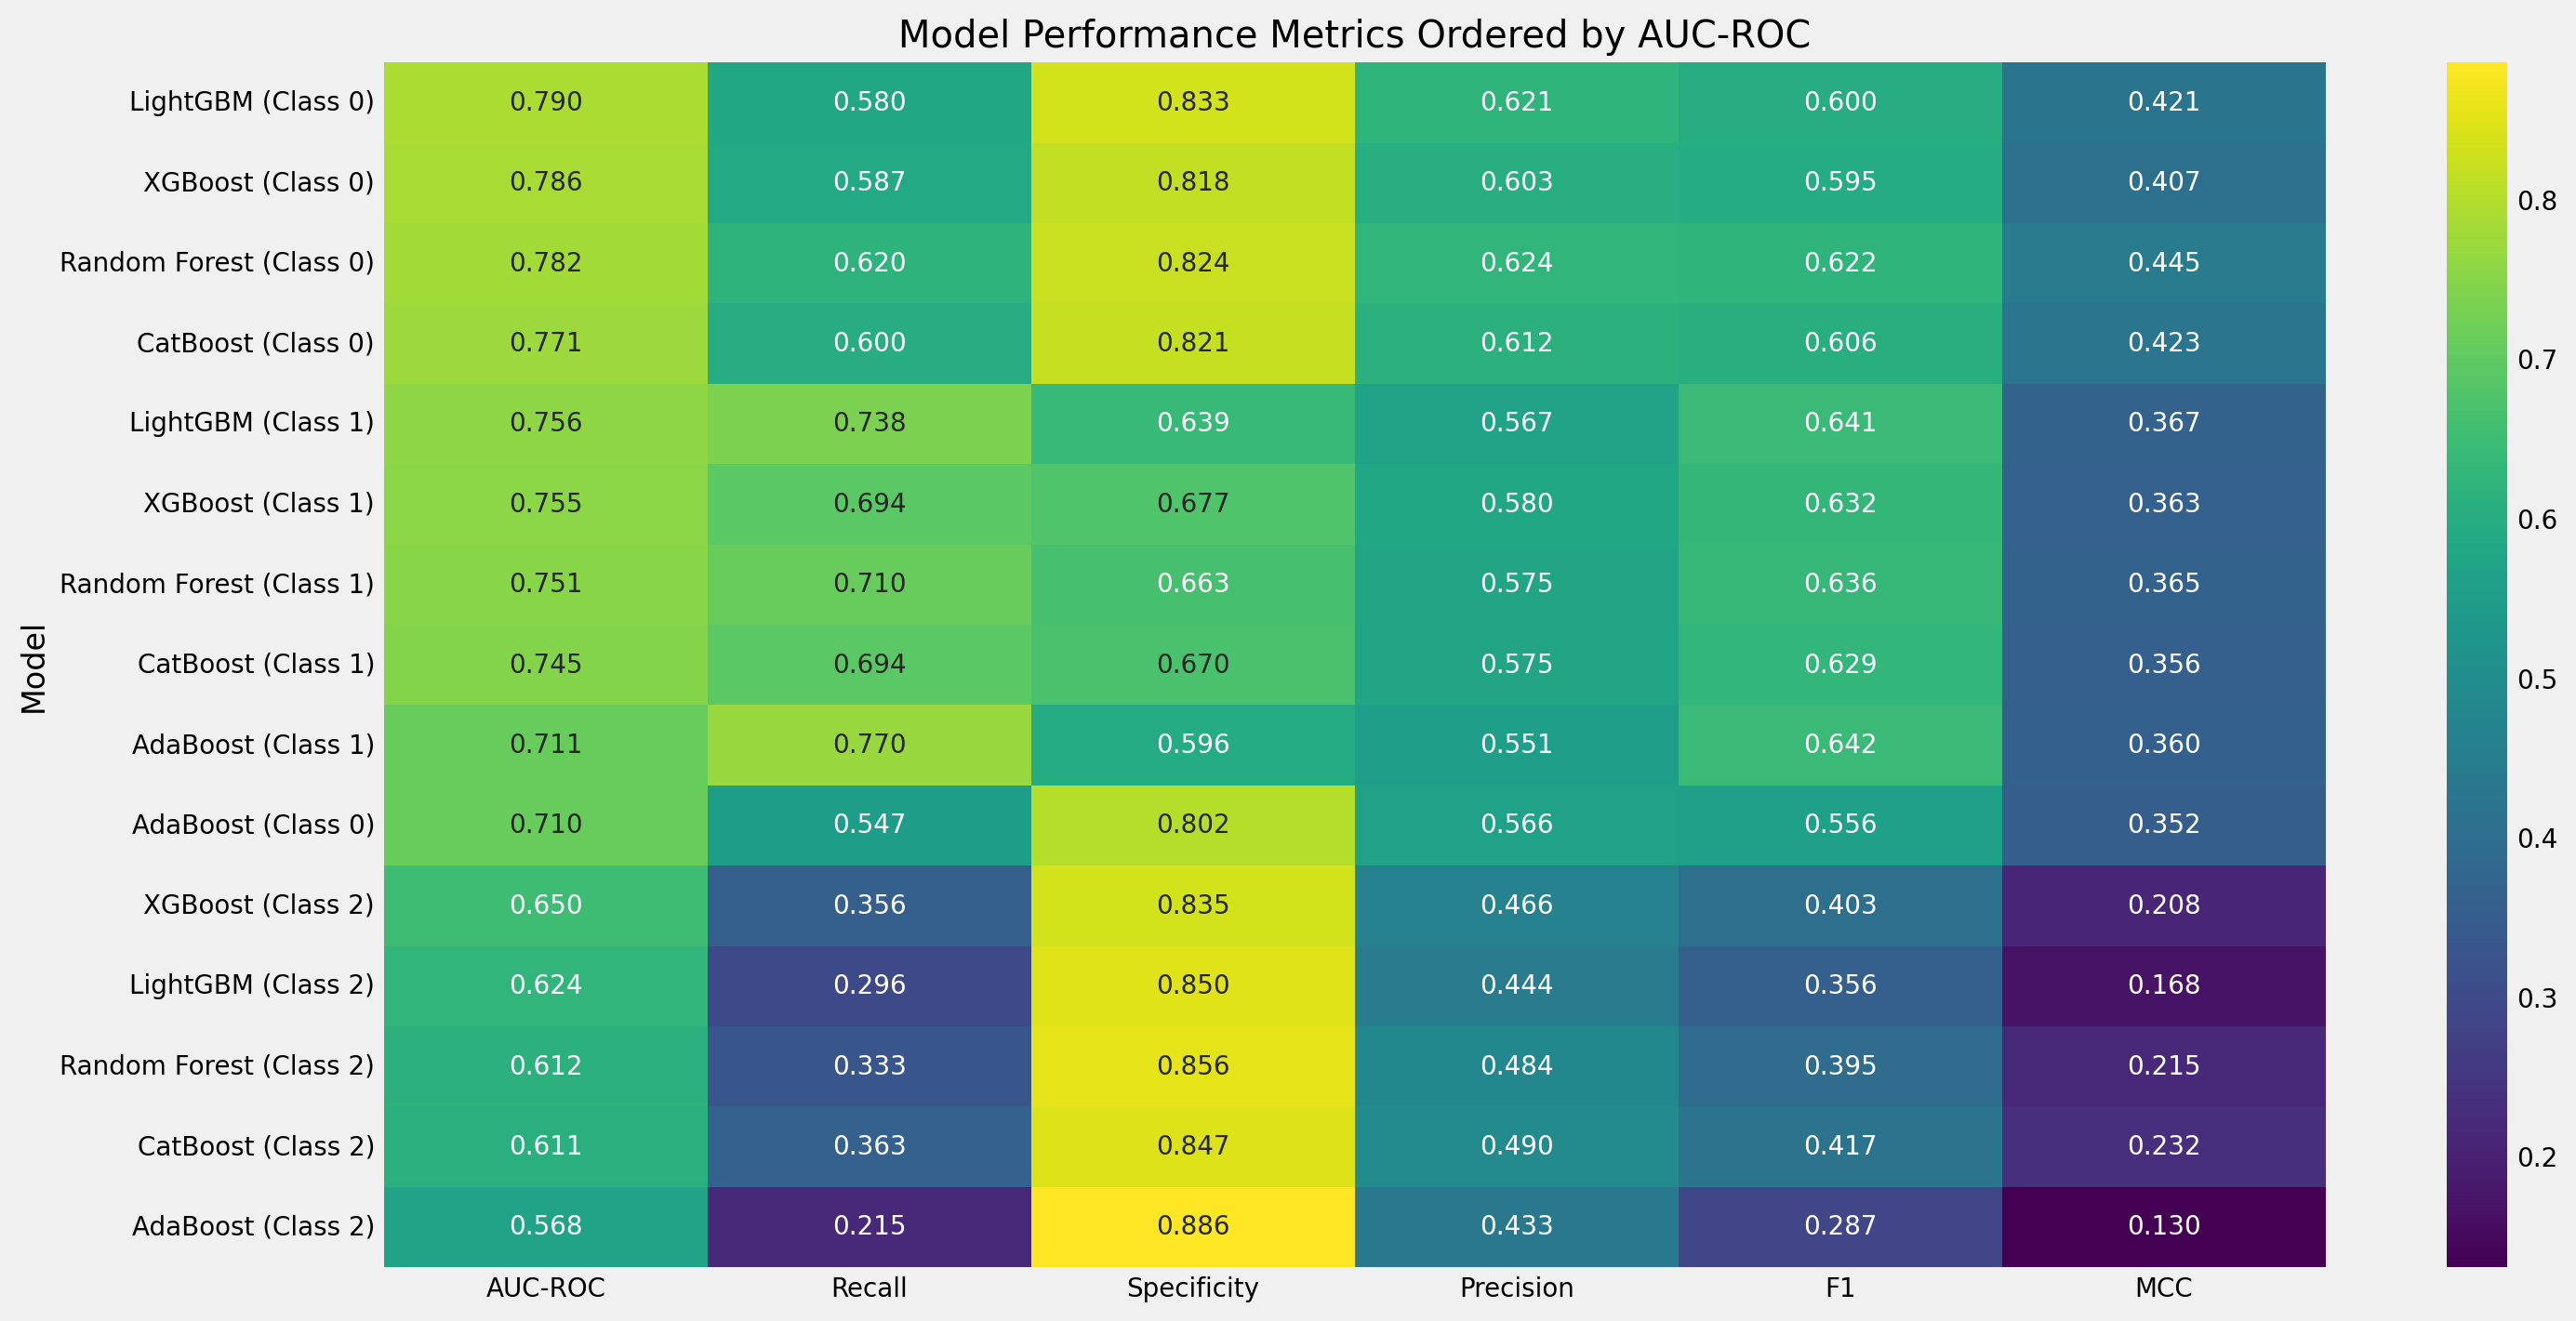

In [ ]:
# Visualizar as métricas como um heatmap (removendo a coluna 'Class')
plt.figure(figsize=(15, 8))
sns.heatmap(metrics_df.set_index('Model').iloc[:, 2:], annot=True, cmap='viridis', cbar=True, fmt='.3f')
plt.title('Model Performance Metrics Ordered by AUC-ROC')
plt.savefig('hiperparameter_tunned.jpg')
plt.show()

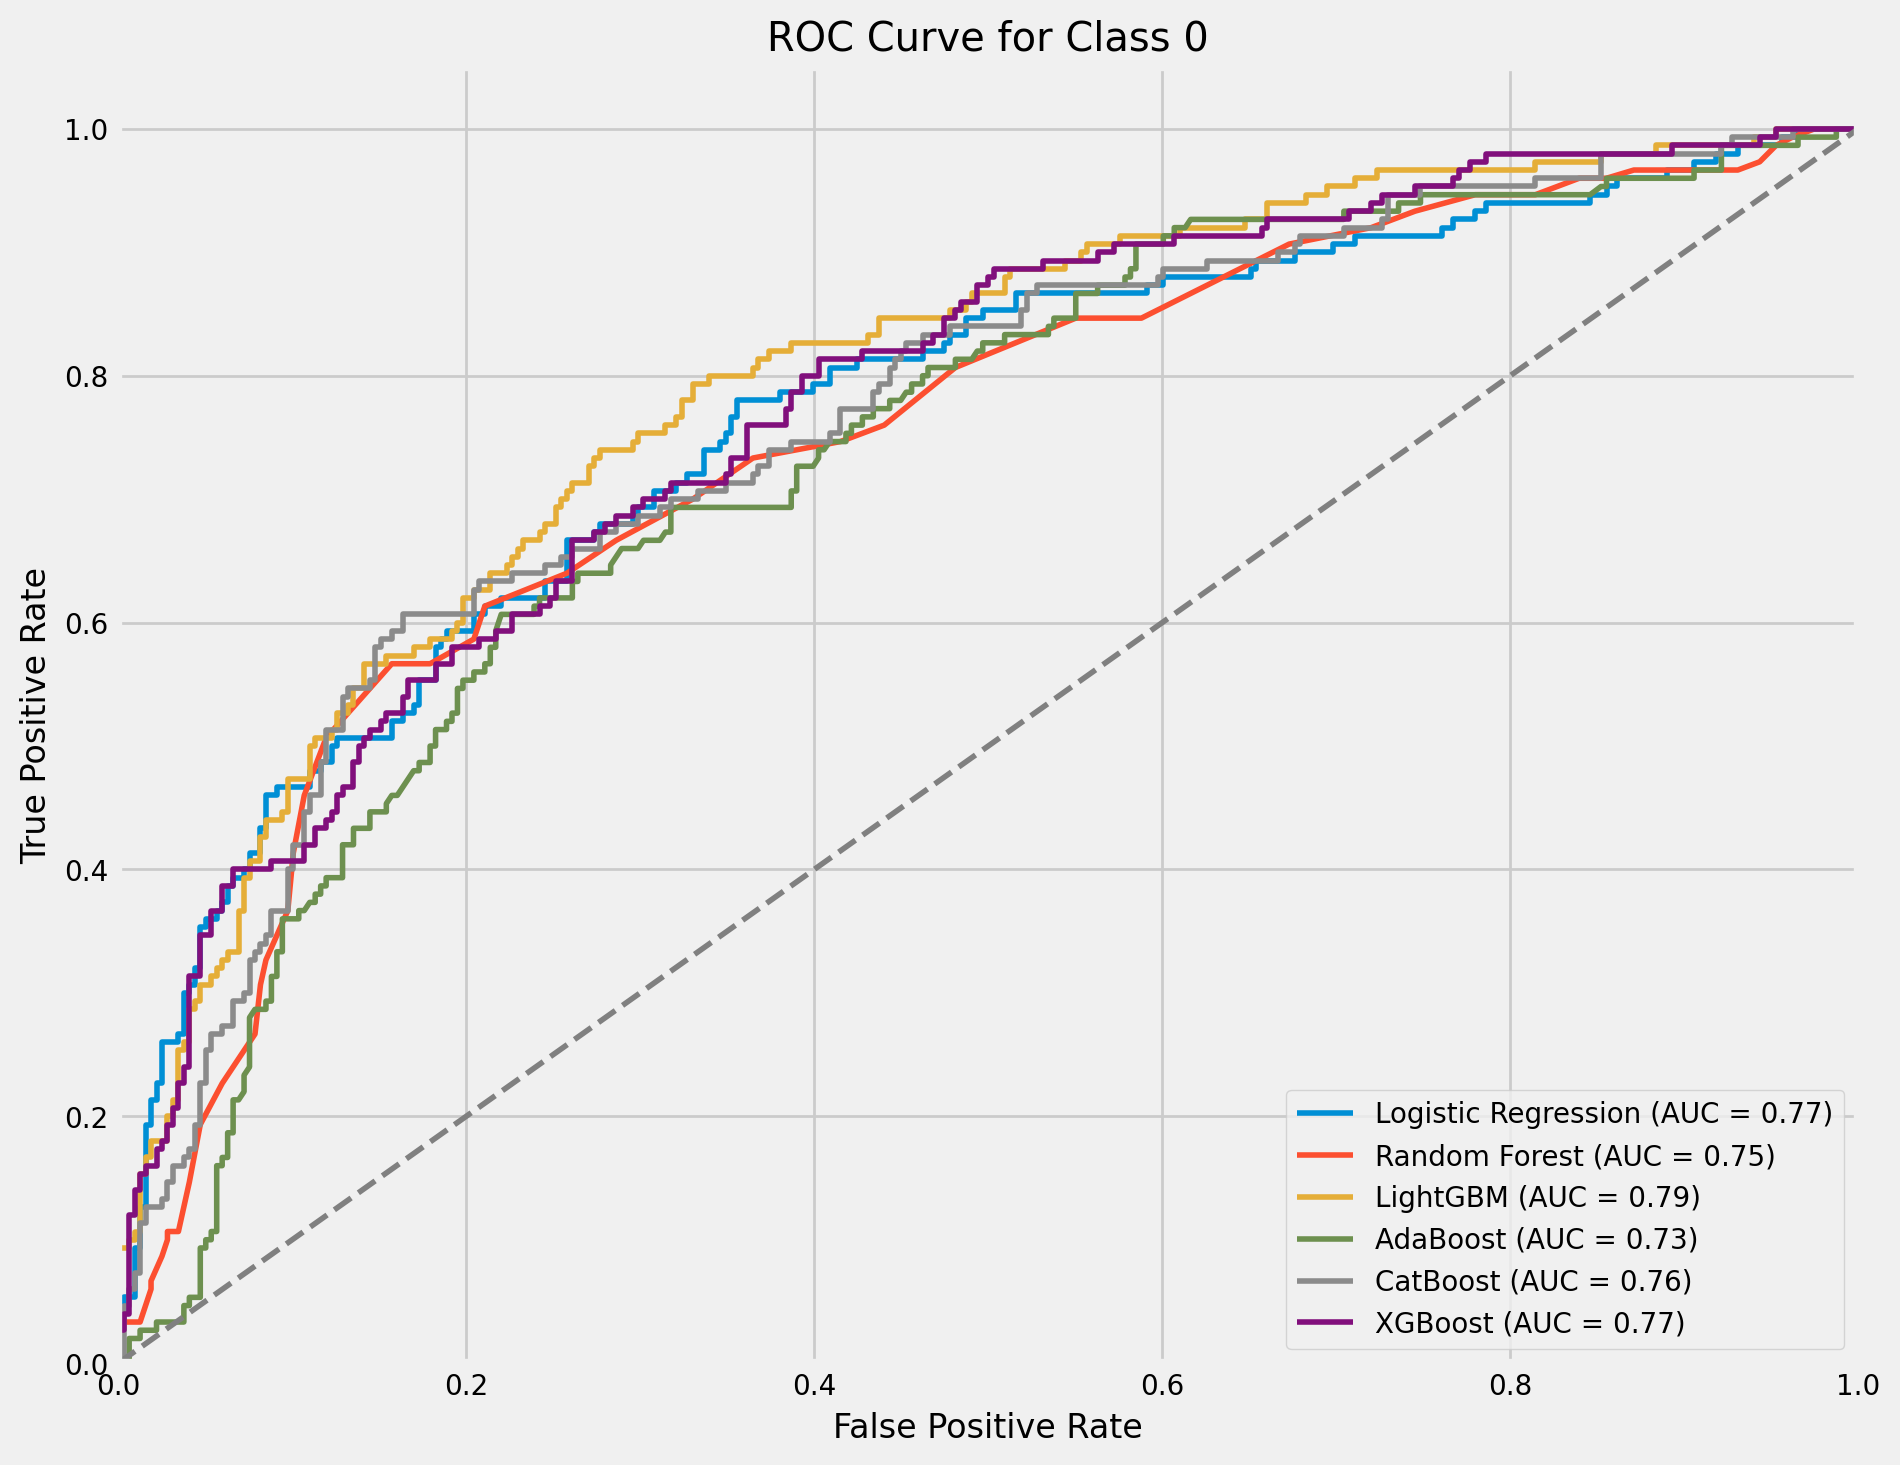

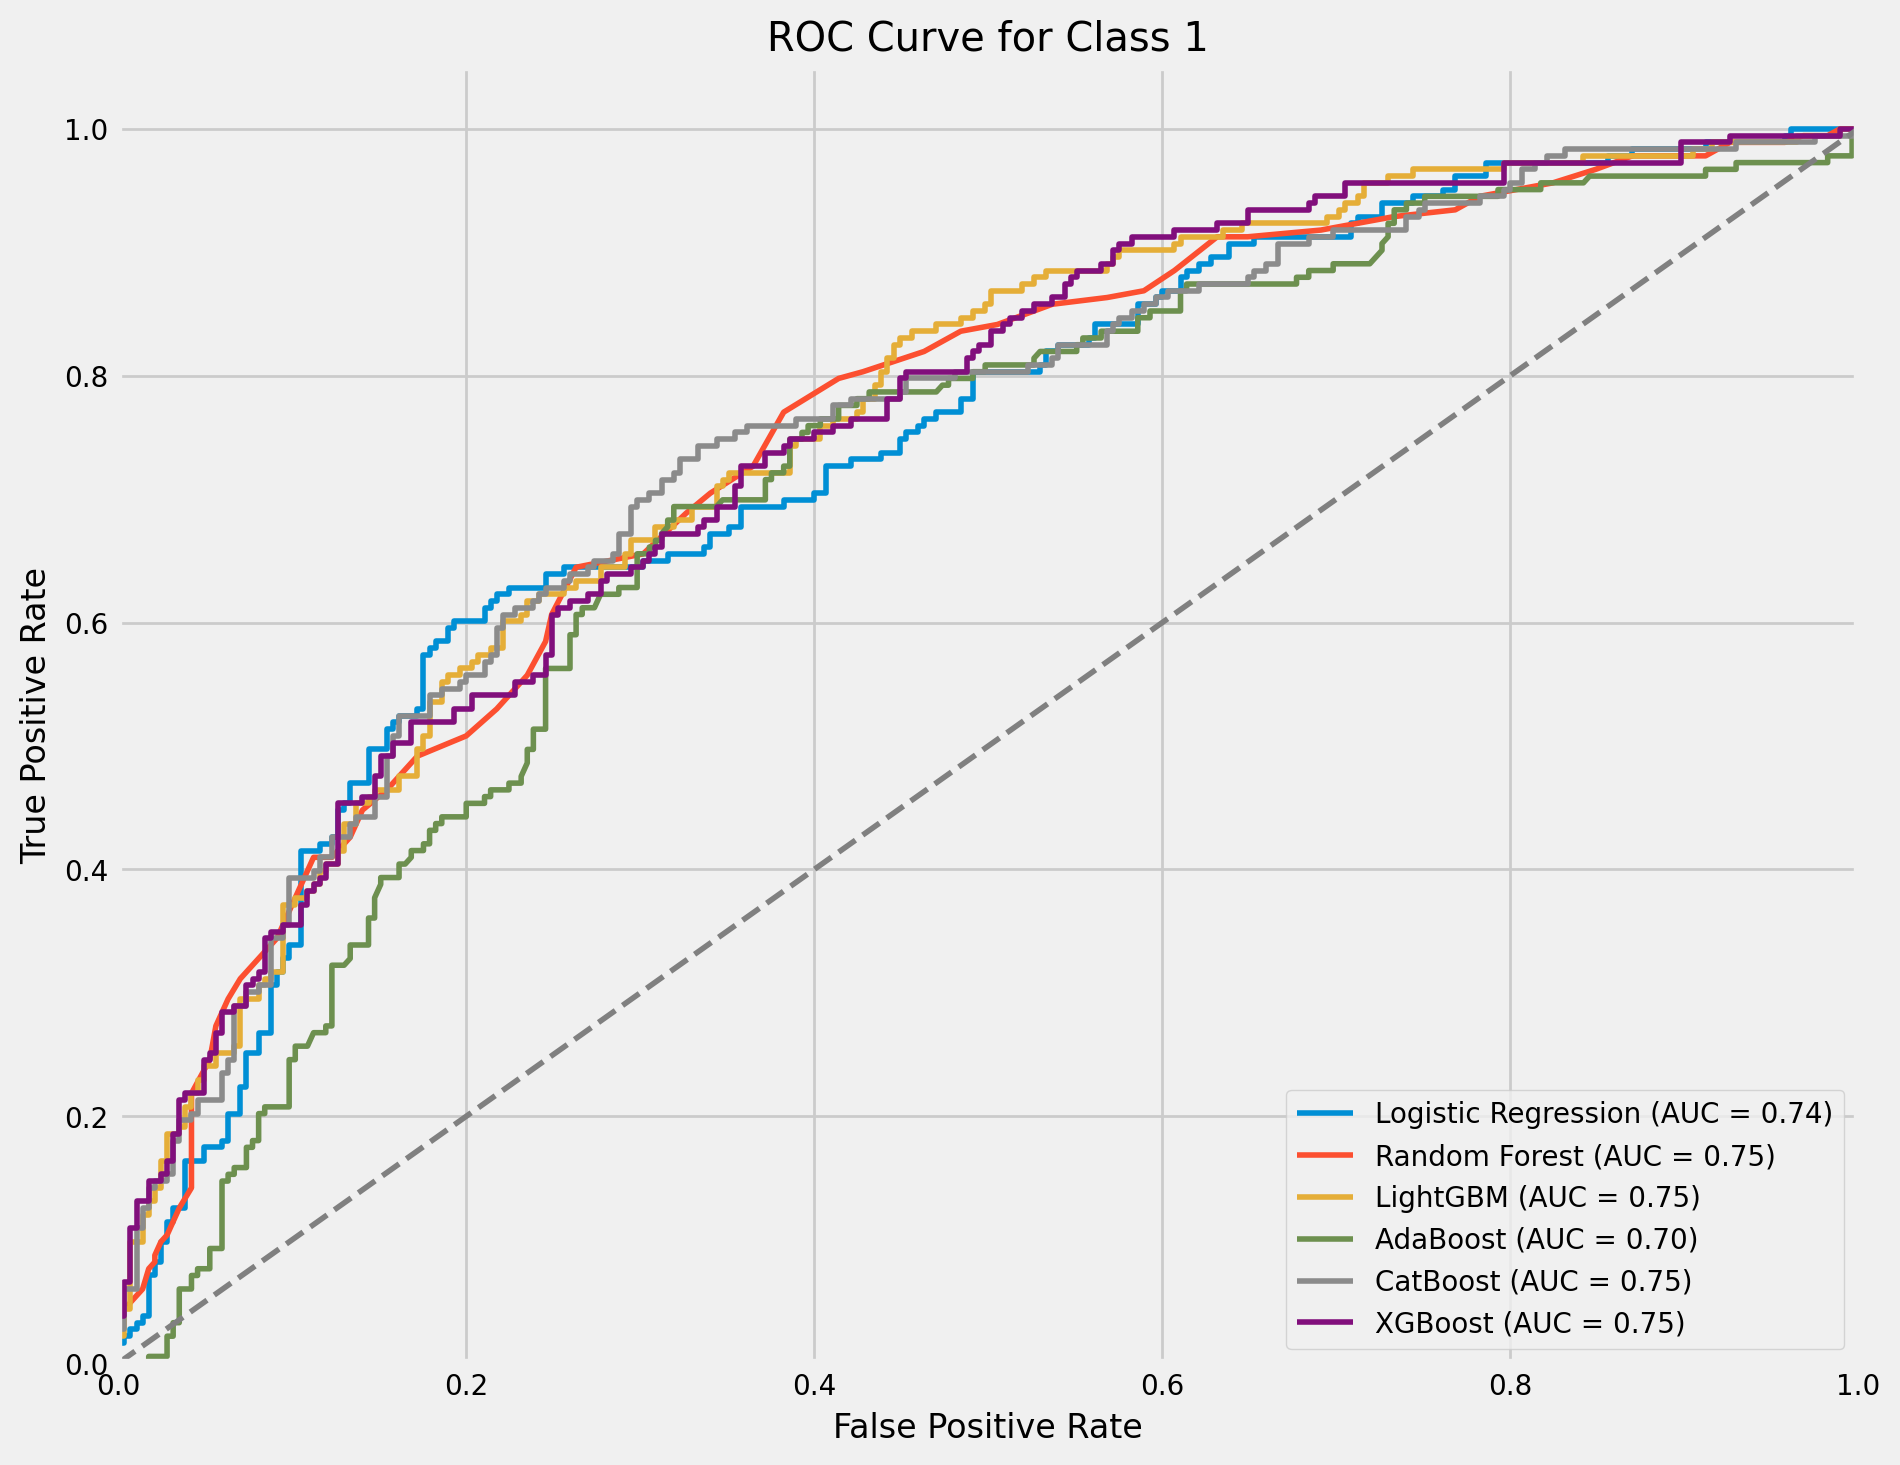

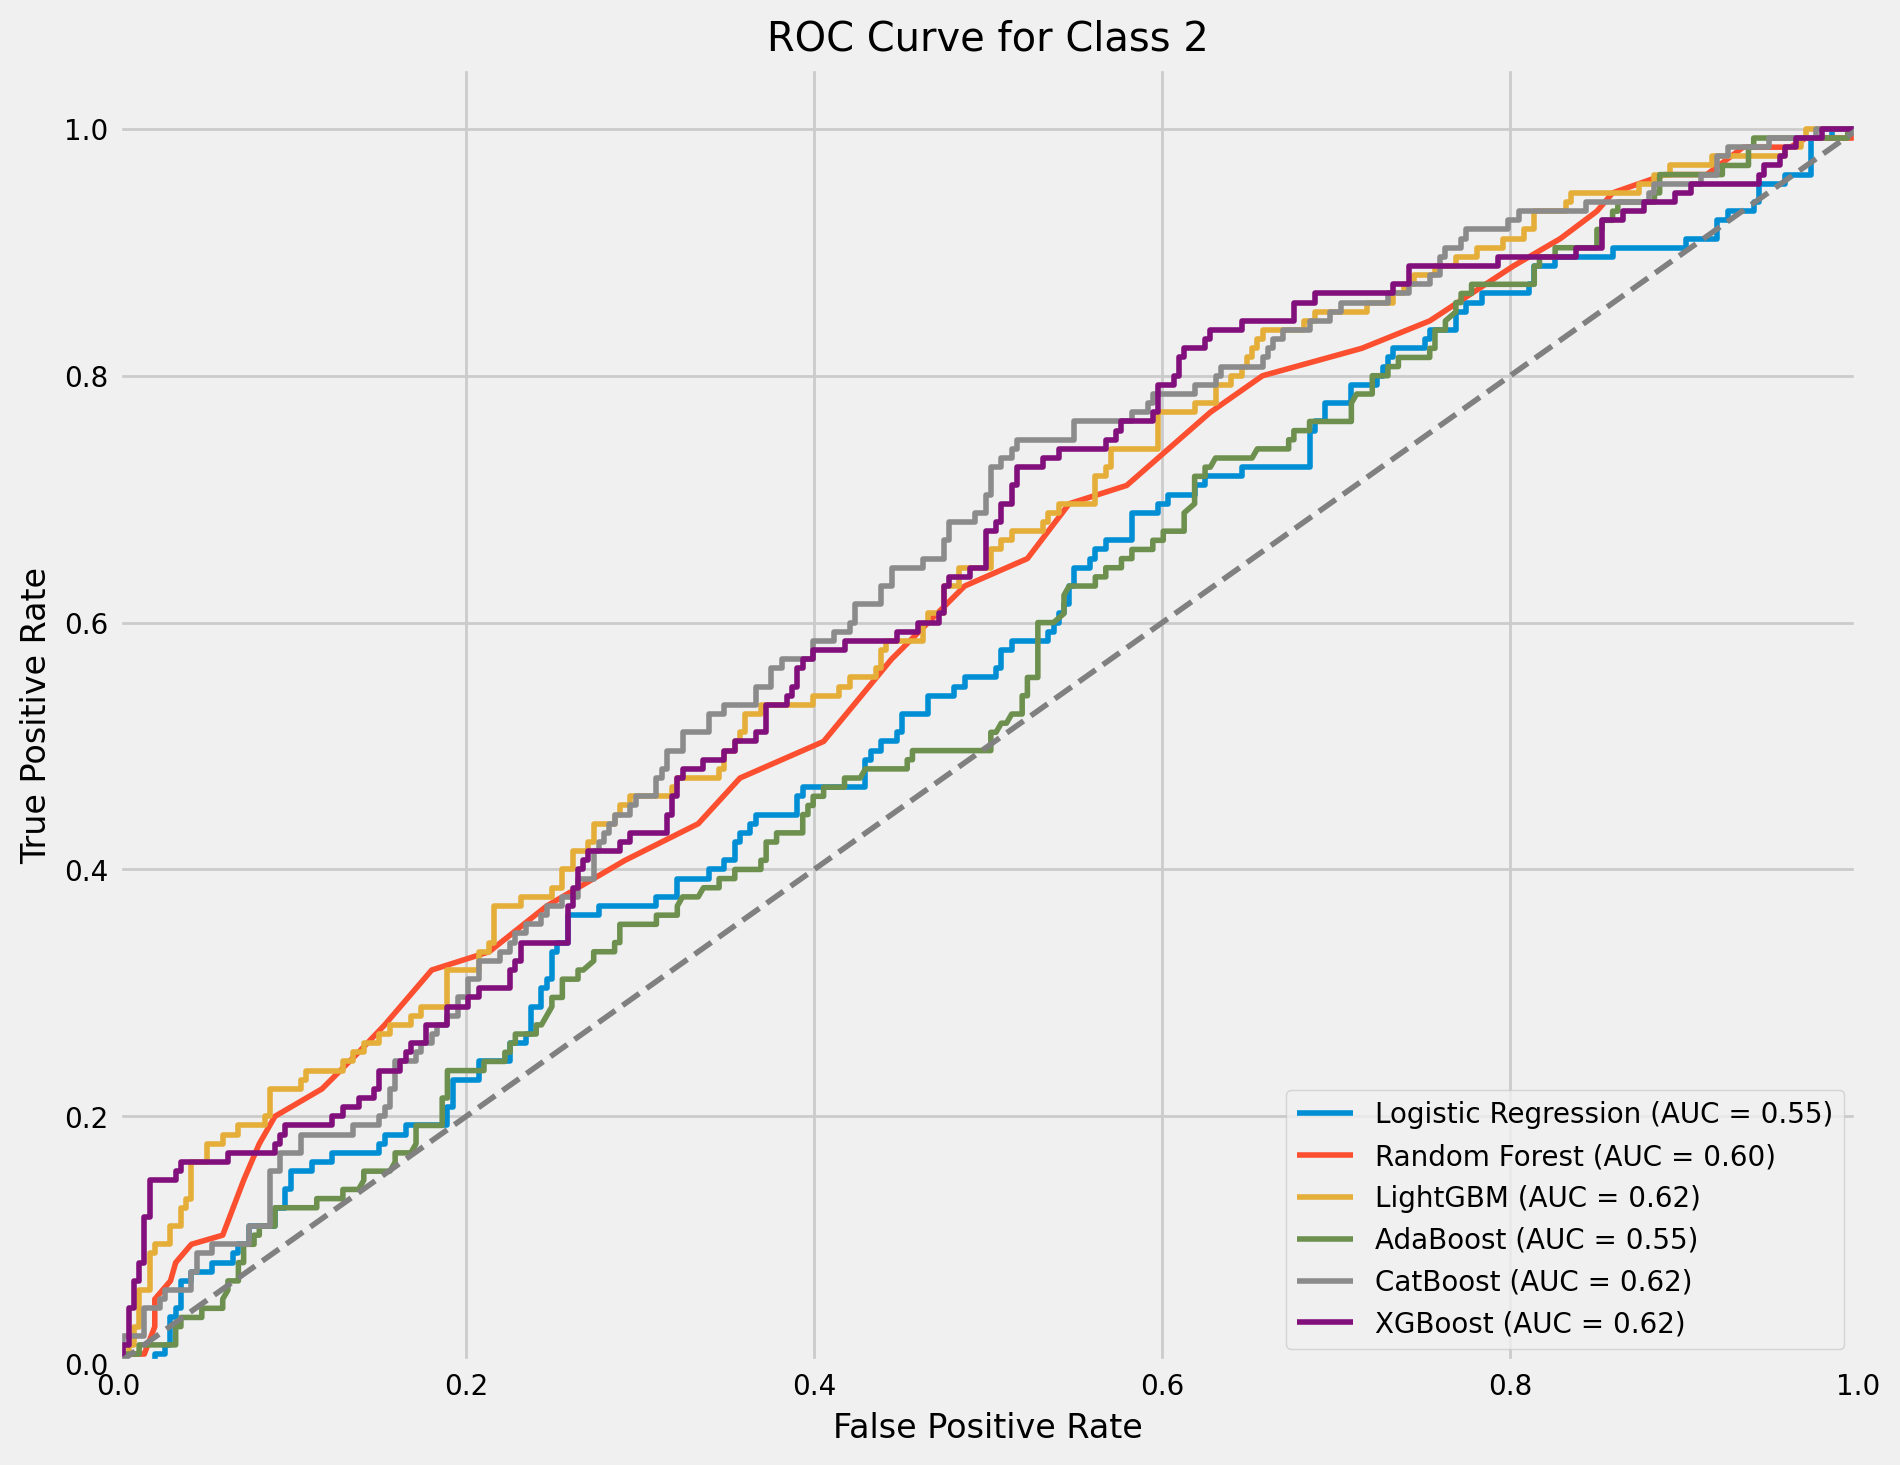

In [ ]:
# Função para plotar as curvas ROC para cada classe
def plot_roc_curves(models, model_probs, y_test, class_label):
    plt.figure(figsize=(10, 8))
    for model_name, y_pred_proba in model_probs.items():
        y_test_bin = (y_test == class_label).astype(int)
        if y_pred_proba.ndim > 1:
            y_pred_proba_bin = y_pred_proba[:, class_label]
        else:
            y_pred_proba_bin = y_pred_proba

        fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba_bin)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {class_label}')
    plt.legend(loc='lower right')
    plt.show()

# Plotar as curvas ROC para cada classe
for class_label in np.unique(y_train):
    plot_roc_curves(models, model_probs, y_test, class_label)

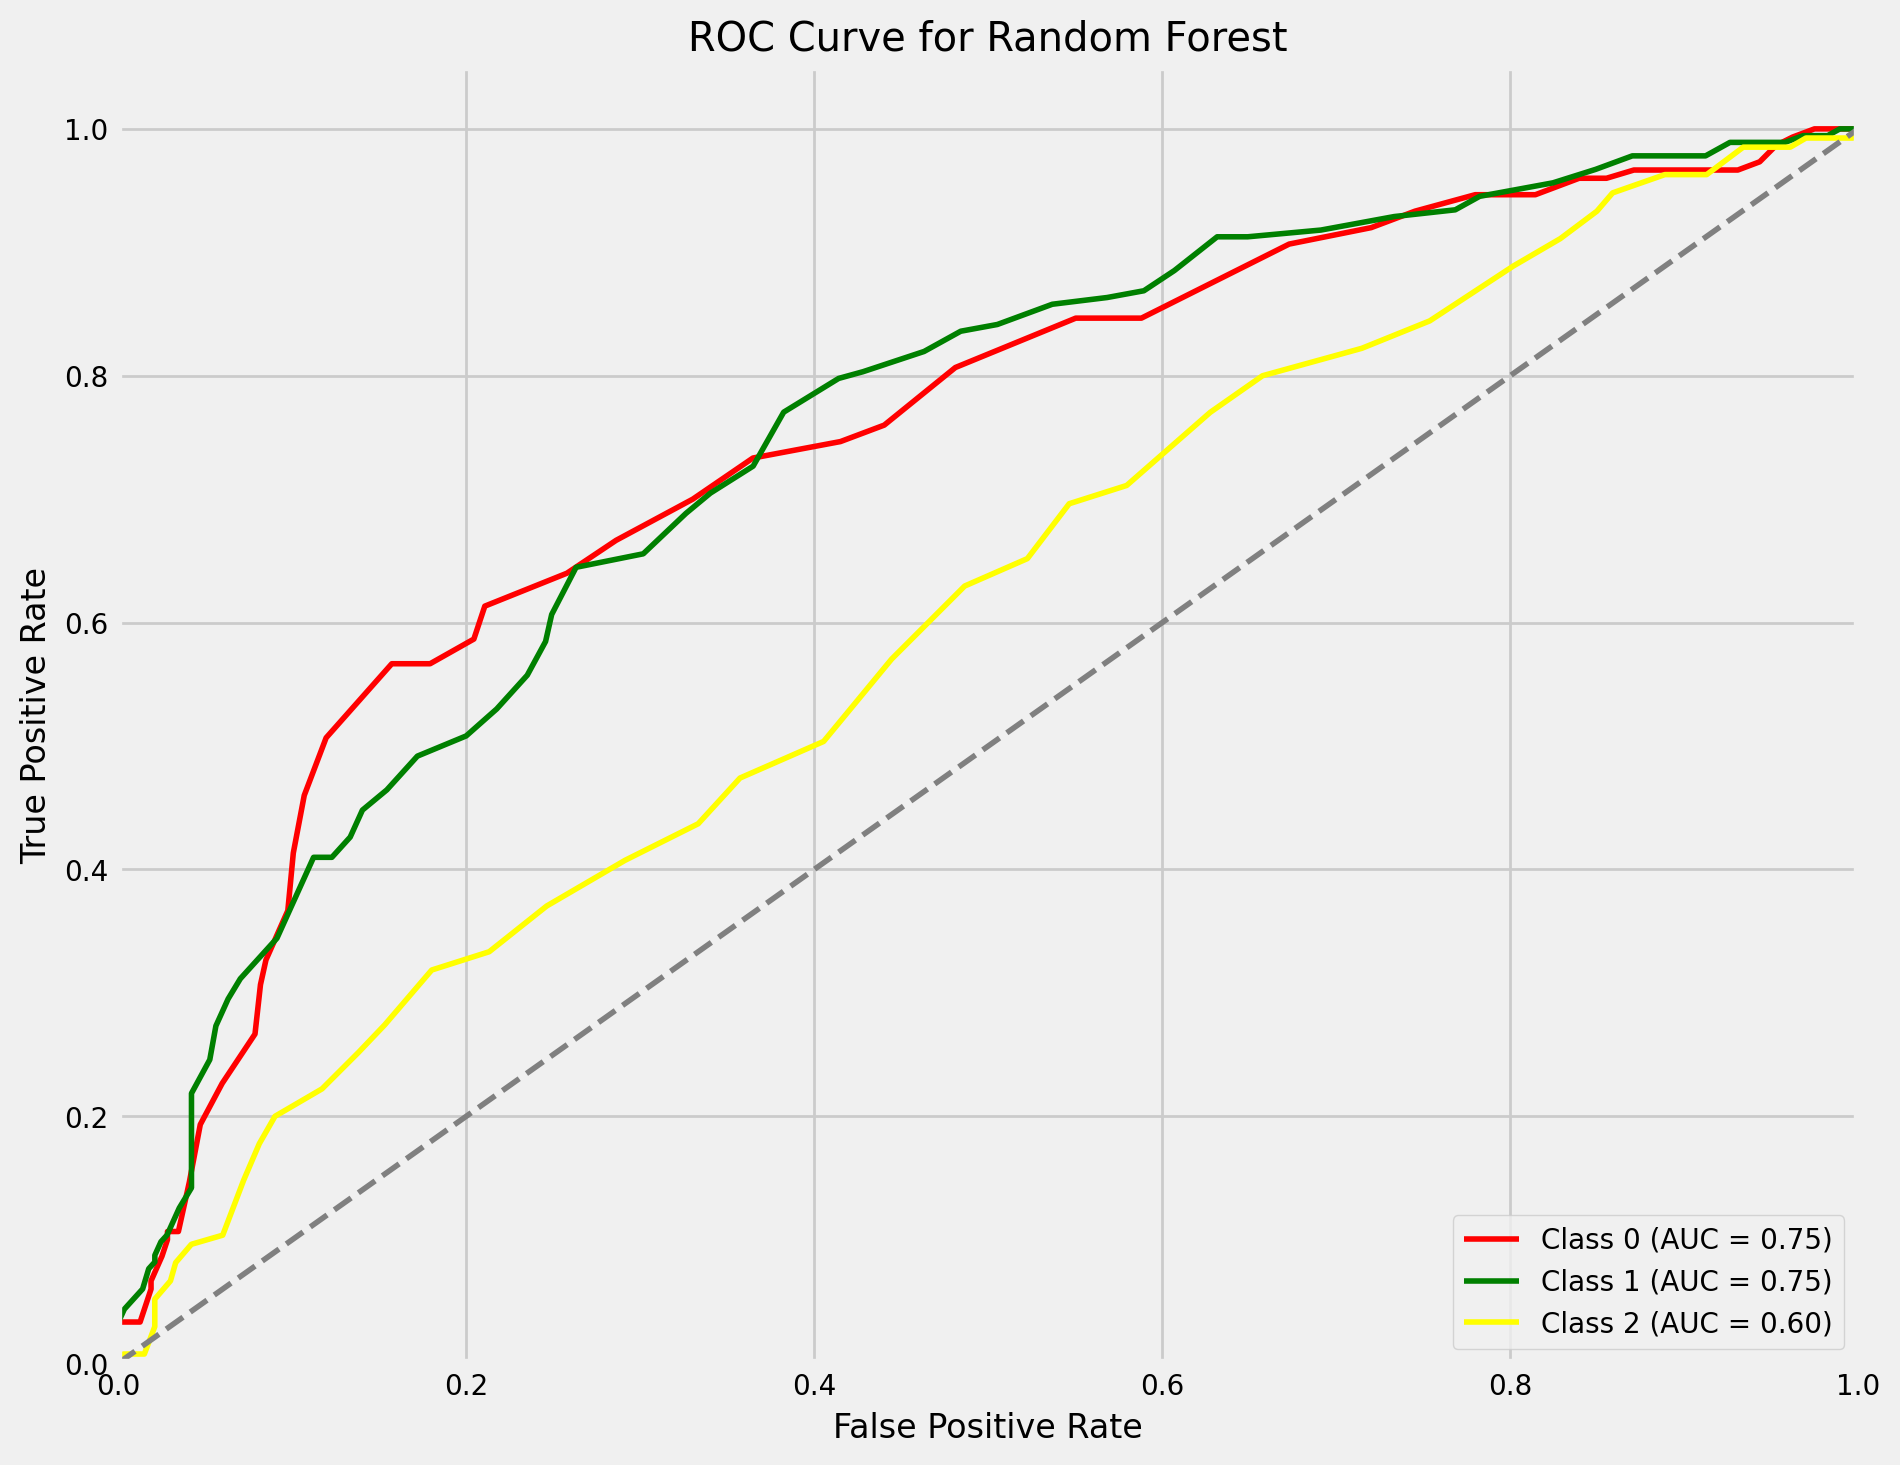

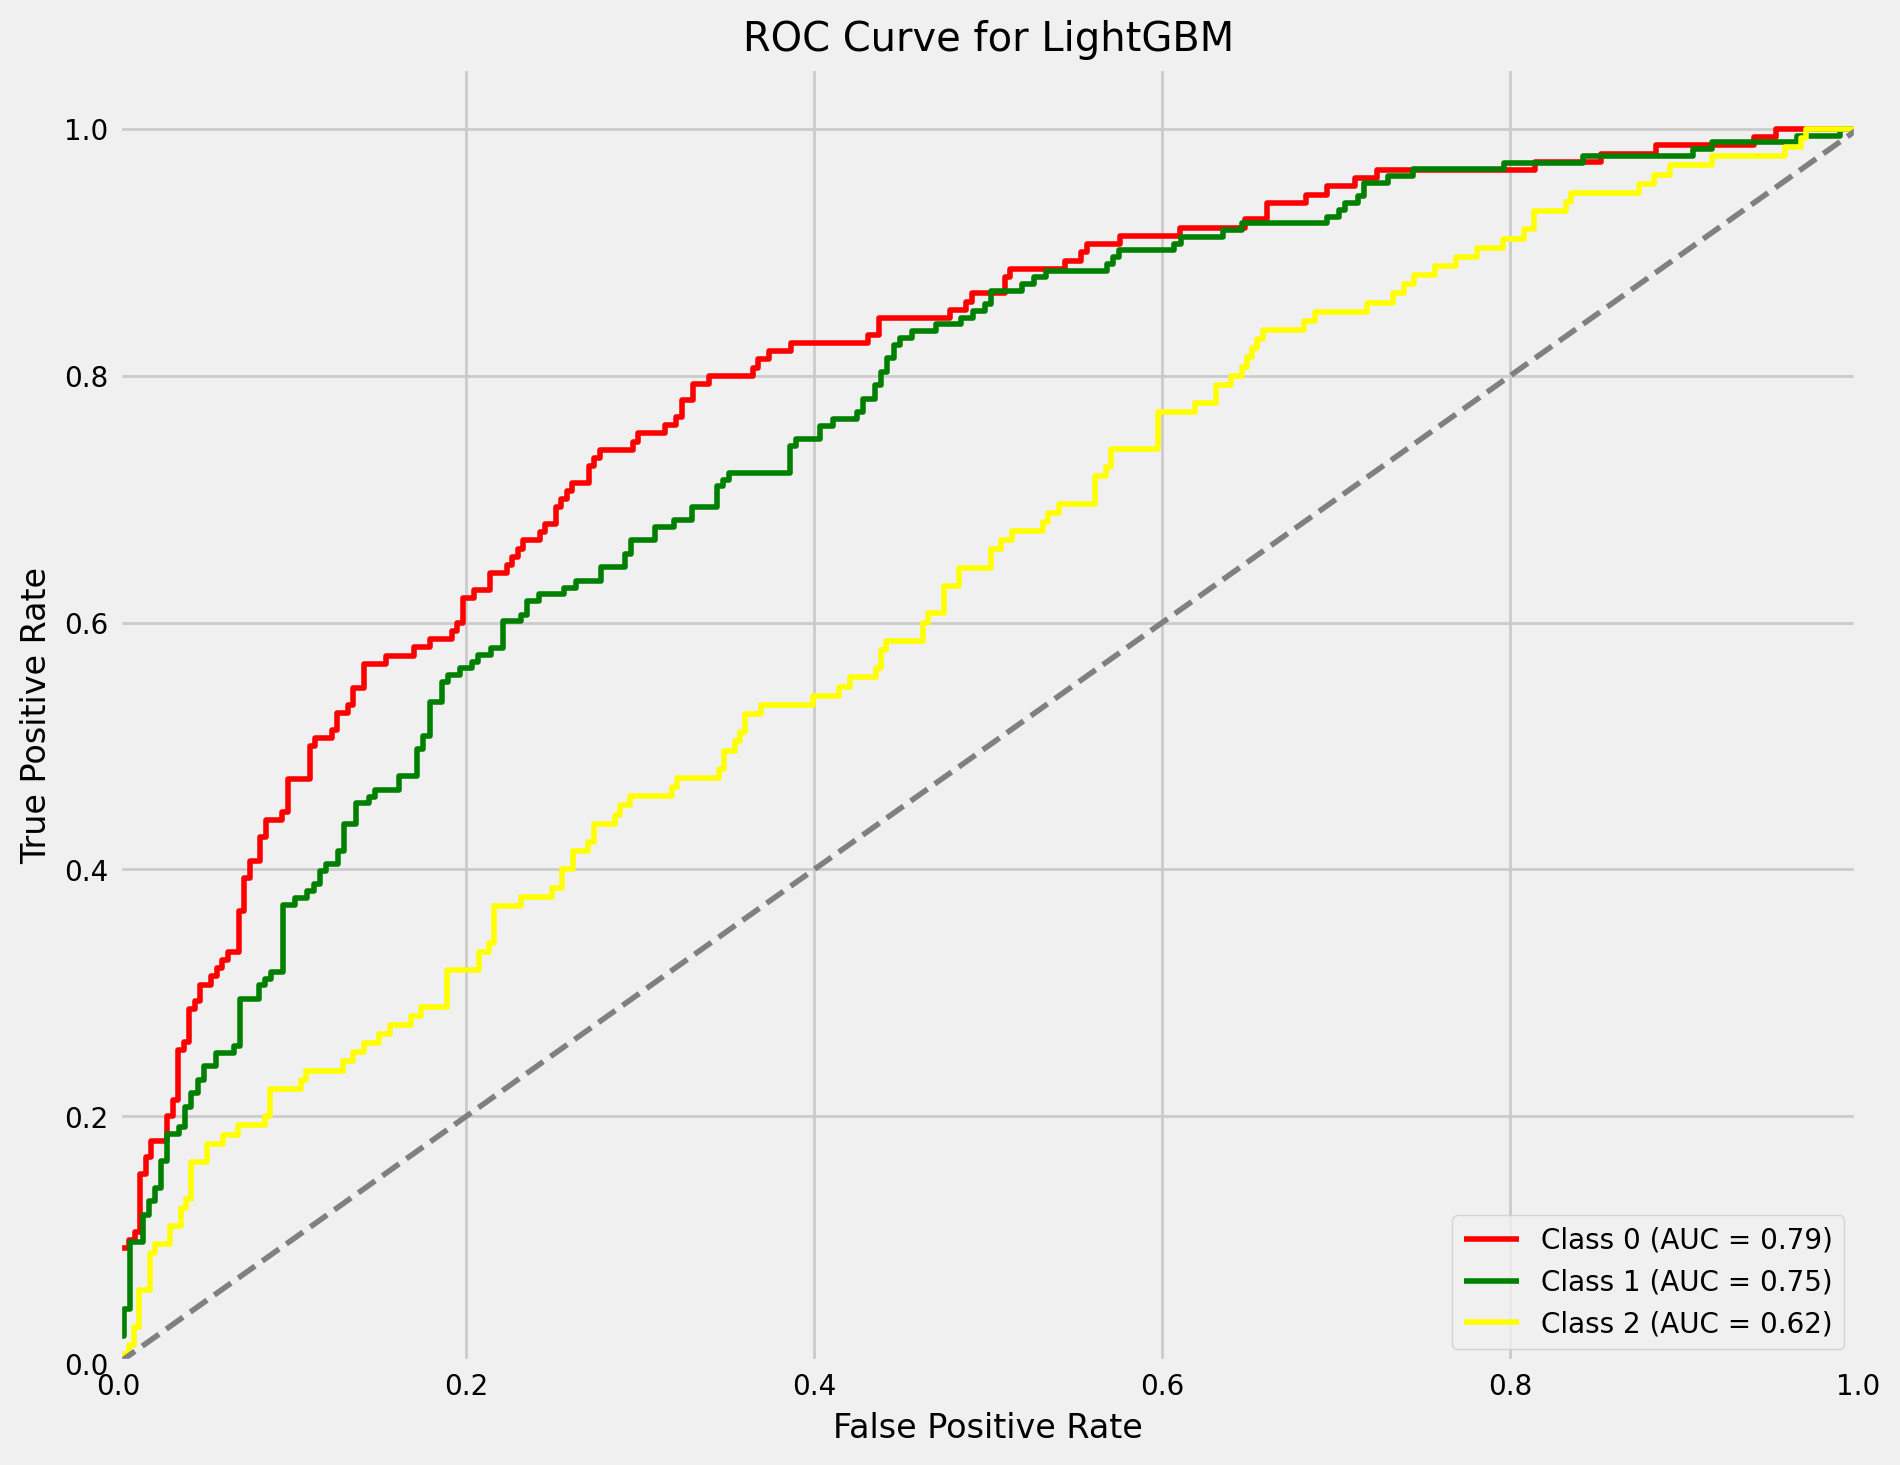

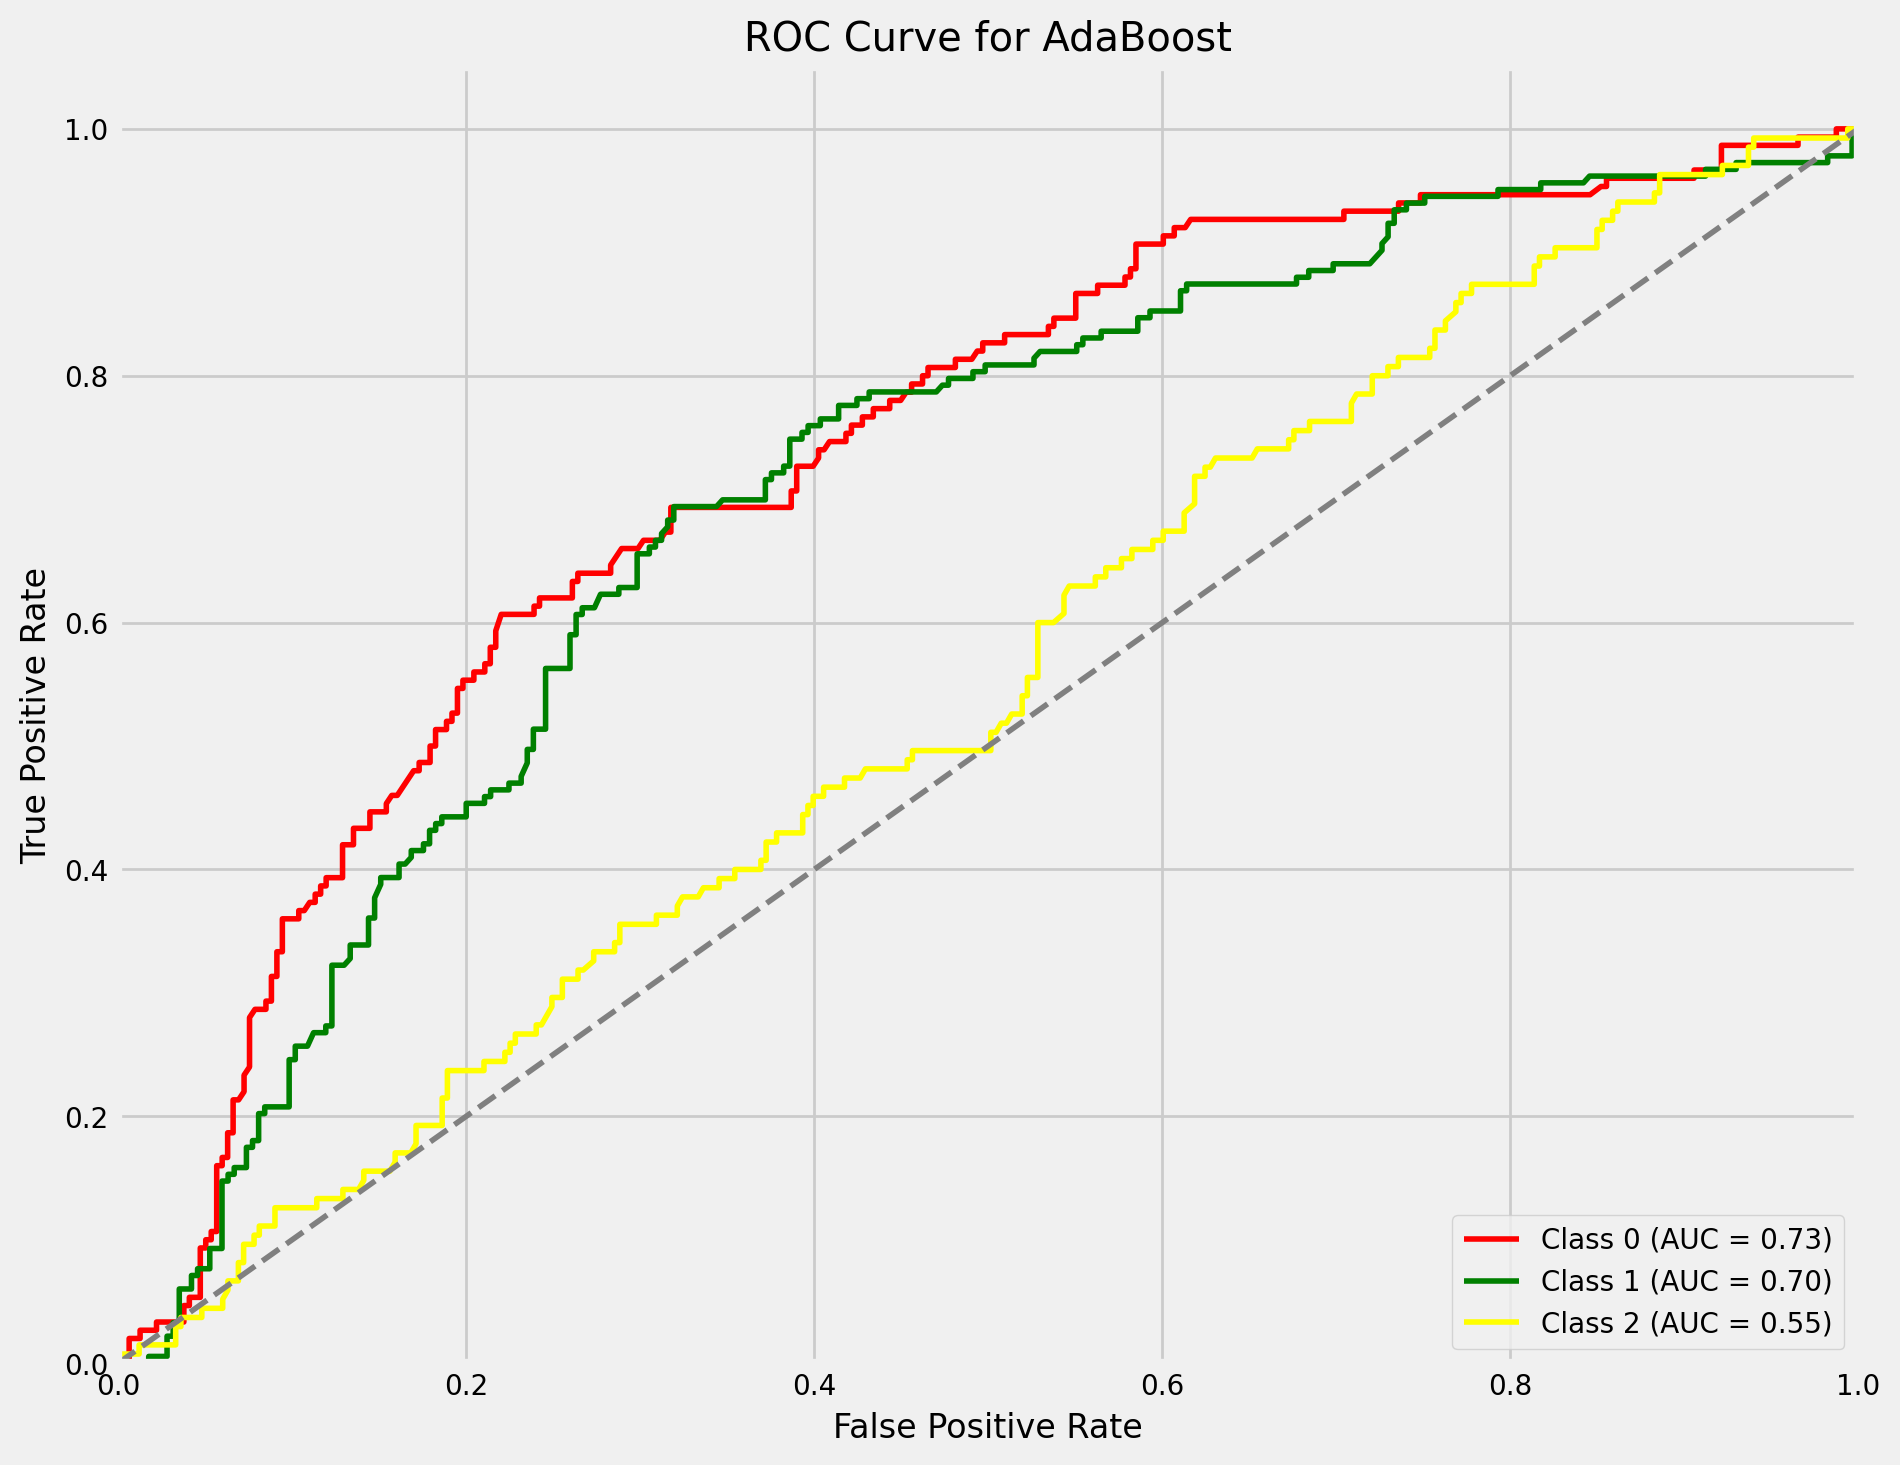

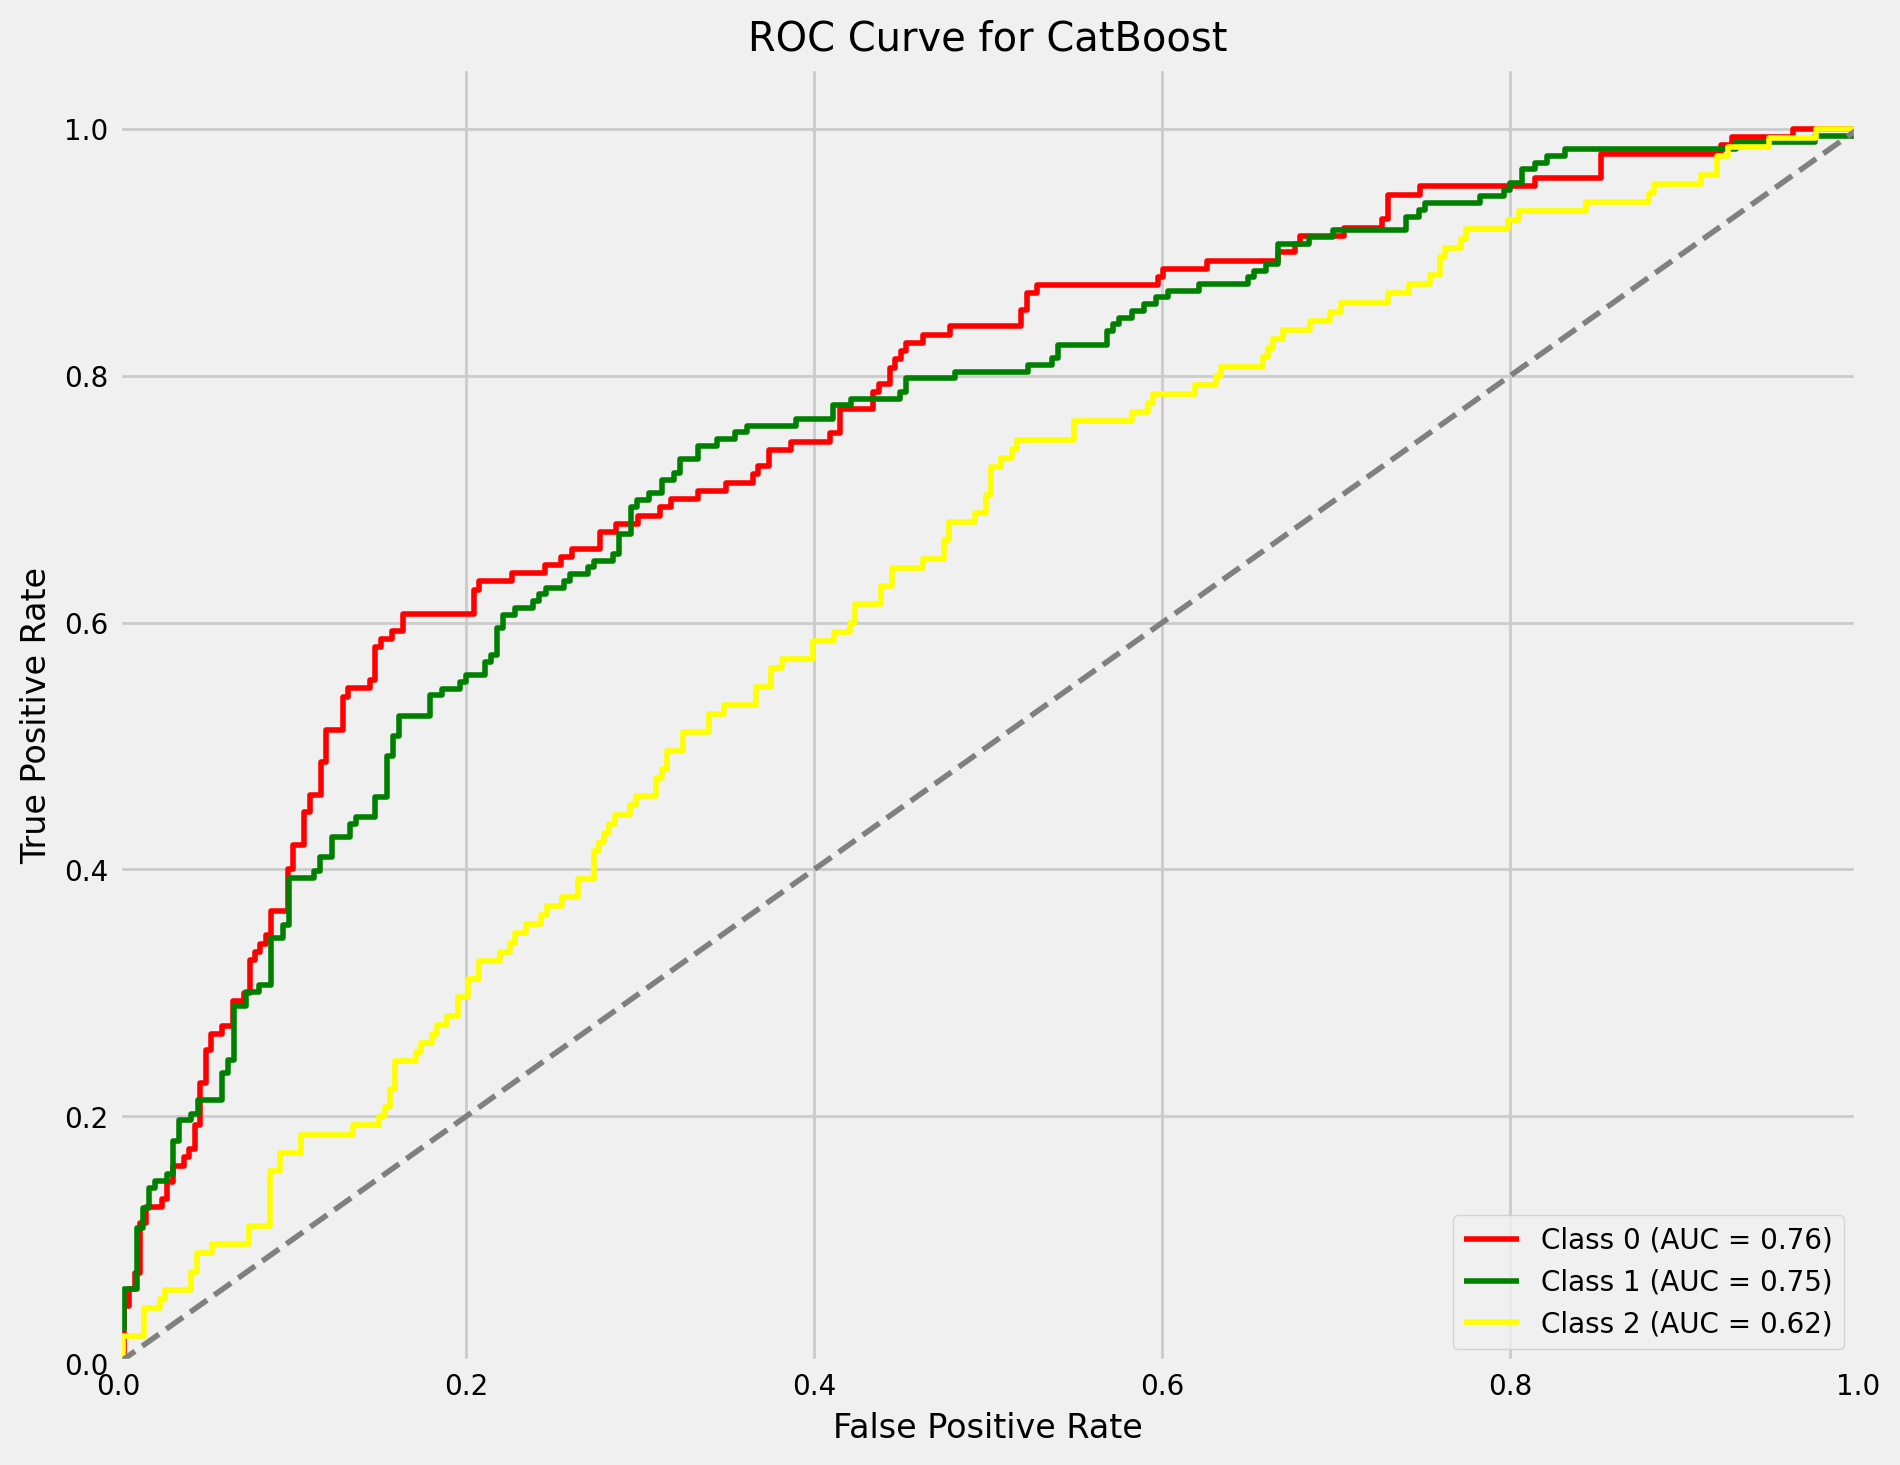

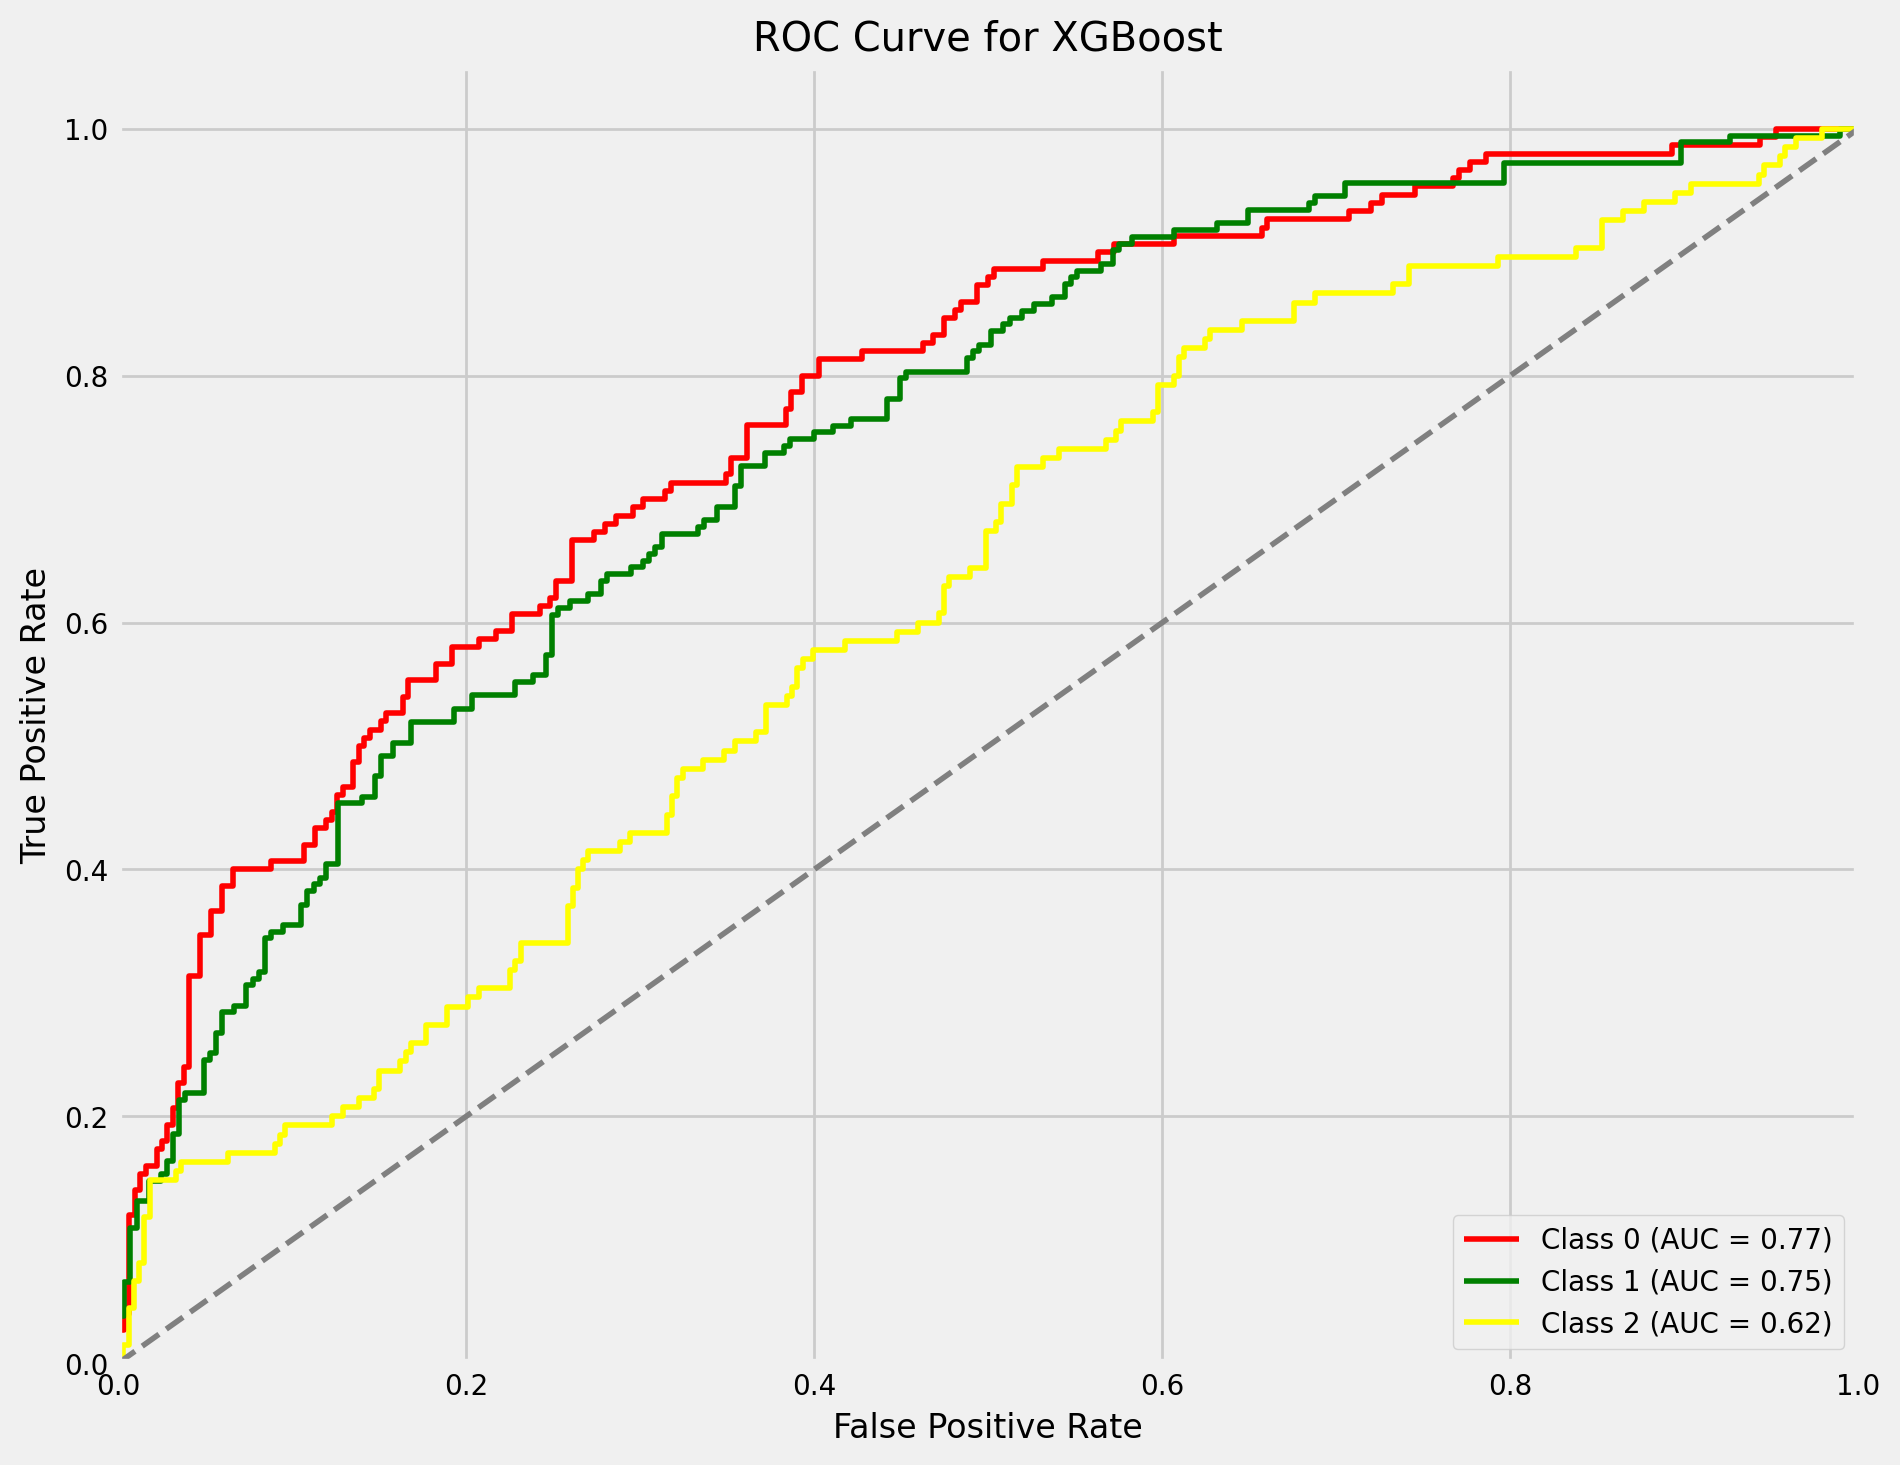

In [ ]:
# Função para plotar as curvas ROC para cada modelo e cada classe
def plot_roc_curves_by_model(models, model_probs, y_test):
    colors = {0: 'red', 1: 'green', 2: 'yellow'}
    for model_name in models.keys():
        plt.figure(figsize=(10, 8))
        for class_label in np.unique(y_test):
            y_test_bin = (y_test == class_label).astype(int)
            y_pred_proba_bin = model_probs[model_name][:, class_label] if model_probs[model_name].ndim > 1 else model_probs[model_name]

            fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba_bin)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, color=colors[class_label], lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.savefig(f'auc-roc_{model_name}')
        plt.show()

# Plotar as curvas ROC para cada modelo
plot_roc_curves_by_model(models, model_probs, y_test)

In [ ]:
X_test.columns

Index(['a_idade', 'a_estat1', 'b_estat1', 'a_pesoat', 'b_pesoat', 'a_pesopre',
       'a_rendpcr', 'a_escola', 'a_hb', 'b_hb', 'a_npari', 'a_npcomo',
       'a_imcpg', 'a_imcga', 'b_imcga', 'a_fmp', 'b_fmp', 'b_hba1c', 'b_hdl',
       'a_ldl', 'a_ct', 'a_pcr', 'b_pcr', 'a_circbracm', 'b_circbracm',
       'a_igadums', 'a_hba1c', 'a_hdl', 'b_ct', 'a_cor_1', 'a_cor_2',
       'a_cor_3', 'a_cor_4', 'a_cor_5', 'a_civil_1', 'a_civil_2', 'a_civil_3',
       'a_civil_4', 'a_vigord_0', 'a_vigord_1', 'a_vigord_2', 'a_vigord_3',
       'a_vigord_4', 'a_vigord_5', 'a_vigord_6', 'a_vigord_7', 'a_moderd_0',
       'a_moderd_1', 'a_moderd_2', 'a_moderd_3', 'a_moderd_4', 'a_moderd_5',
       'a_moderd_6', 'a_moderd_7', 'b_vigord_0.0', 'b_vigord_1.0',
       'b_vigord_2.0', 'b_vigord_3.0', 'b_vigord_4.0', 'b_vigord_5.0',
       'b_vigord_6.0', 'b_vigord_7.0', 'b_moderd_0.0', 'b_moderd_1.0',
       'b_moderd_2.0', 'b_moderd_3.0', 'b_moderd_4.0', 'b_moderd_5.0',
       'b_moderd_6.0', 'b_moderd_7.0'],
 

In [ ]:
 feature_mapping = {
    'a_idade': 'Maternal age ',
    'a_estat1': 'Height ',
    'b_estat1': 'Height ',
    'a_pesopre': 'Pre-gestational weight ',
    'b_pesoat': 'Gestational weight (2nd trimester)',
    'a_pesoat': 'Gestational weight (1nd trimester)',
    'a_circbracm': 'Arm circumference (1st trimester)',
    'b_circbracm': 'Arm circumference (2nd trimester)',
    'a_rendpcr': 'Per capita income',
    'a_escola': '"Years of schooling (1st trimester)',
    'a_hb': 'Hemoglobin (1st trimester)',
    'b_hb': 'Hemoglobin (2nd trimester)',
    'a_npari': 'Number of previous pregnancies (1st trimester)',
    'a_npcomo': 'Number of previous deliveries (1st trimester)',
    'a_imcpg': 'Pre-gestational BMI',
    'a_imcga': 'Gestational BMI (1st trimester)',
    'b_imcga': 'Ggestational BMI (2nd trimester)',
    'a_fmp': 'Body fat (%) (1st trimester)',
    'b_fmp': 'Body fat (%)(2nd trimester)',
    'a_hba1c': 'Glycated hemoglobin (1st trimester)',
    'a_pcr': 'C-reactive protein (1st trimester)',
    'b_pcr': 'C-reactive protein (2nd trimester)',
    'b_hdl': 'HDL (2nd trimester)',
    'a_hdl': 'HDL (1st trimester)',
    'b_ldl': 'LDL (2nd trimester)',
    'a_ldl': 'LDL (1st trimester)',
    'b_ct': 'Cholesterol (2nd trimester)',
    'a_ct': 'Cholesterol (1st trimester)',
    'a_cor_1': 'Race (1st trimester) - White',
    'a_cor_2': 'Race (1st trimester) - Black',
    'a_cor_3': 'Race (1st trimester) - Asian',
    'a_cor_4': 'Race (1st trimester) - Indigenous',
    'a_cor_5': 'Race (1st trimester) - Mixed',
    'a_civil_1': 'Marital status (1st trimester) - Married',
    'a_civil_2': 'Marital status (1st trimester) - Single (with partner)',
    'a_civil_3': 'Marital status (1st trimester) - Single (without partner)',
    'a_vigord_1': 'Physical activity (1st trimester) - Yes',
    'a_vigord_2': 'Physical activity (1st trimester) - No',
    'a_fumog_1': 'Smoking (1st trimester) - Yes',
    'a_fumog_2': 'Smoking (1st trimester) - No',
    'a_agdm_1': 'Diabetes (1st trimester)',
    'a_aghas_1': 'Hypertension (1st trimester)',
    'a_igadums_1': 'Gestational age in weeks (1st trimester)',
    'b_cor_1': 'Race (2nd trimester) - White',
    'b_cor_2': 'Race (2nd trimester) - Black',
    'b_cor_3': 'Race (2nd trimester) - Asian',
    'b_cor_4': 'Race (2nd trimester) - Indigenous',
    'b_cor_5': 'Race (2nd trimester) - Mixed',
    'b_civil_1': 'Marital status (2nd trimester) - Married',
    'b_civil_2': 'Marital status (2nd trimester) - Single (with partner)',
    'b_civil_3': 'Marital status (2nd trimester) - Single (without partner)',
    'b_vigord_1': 'Physical activity (2nd trimester) - Yes',
    'b_vigord_2': 'Physical activity (2nd trimester) - No',
    'b_fumog_1': 'Smoking (2nd trimester) - Yes',
    'b_fumog_2': 'Smoking (2nd trimester) - No',
    'b_agdm_1': 'Diabetes (2nd trimester)',
    'b_aghas_1': 'Hypertension (2nd trimester)',
    'b_igadums_1': 'Gestational age in weeks (2nd trimester)',
    'b_npari_1': 'Number of previous pregnancies (2nd trimester)',
    'b_escola': 'Years of schooling (2nd trimester)',
    'b_hba1c': 'Glycated hemoglobin (2nd trimester)',
    'b_hdl': 'HDL (2nd trimester)',
    'b_ldl': 'LDL (2nd trimester)',
    'b_ct': 'Cholesterol (2nd trimester)'
}

In [ ]:
X_test.columns

Index(['a_idade', 'a_estat1', 'b_estat1', 'a_pesoat', 'b_pesoat', 'a_pesopre',
       'a_rendpcr', 'a_escola', 'a_hb', 'b_hb', 'a_npari', 'a_npcomo',
       'a_imcpg', 'a_imcga', 'b_imcga', 'a_fmp', 'b_fmp', 'b_hba1c', 'b_hdl',
       'a_ldl', 'a_ct', 'a_pcr', 'b_pcr', 'a_circbracm', 'b_circbracm',
       'a_igadums', 'a_hba1c', 'a_hdl', 'b_ct', 'a_cor_1', 'a_cor_2',
       'a_cor_3', 'a_cor_4', 'a_cor_5', 'a_civil_1', 'a_civil_2', 'a_civil_3',
       'a_civil_4', 'a_vigord_0', 'a_vigord_1', 'a_vigord_2', 'a_vigord_3',
       'a_vigord_4', 'a_vigord_5', 'a_vigord_6', 'a_vigord_7', 'a_moderd_0',
       'a_moderd_1', 'a_moderd_2', 'a_moderd_3', 'a_moderd_4', 'a_moderd_5',
       'a_moderd_6', 'a_moderd_7', 'b_vigord_0.0', 'b_vigord_1.0',
       'b_vigord_2.0', 'b_vigord_3.0', 'b_vigord_4.0', 'b_vigord_5.0',
       'b_vigord_6.0', 'b_vigord_7.0', 'b_moderd_0.0', 'b_moderd_1.0',
       'b_moderd_2.0', 'b_moderd_3.0', 'b_moderd_4.0', 'b_moderd_5.0',
       'b_moderd_6.0', 'b_moderd_7.0'],
 

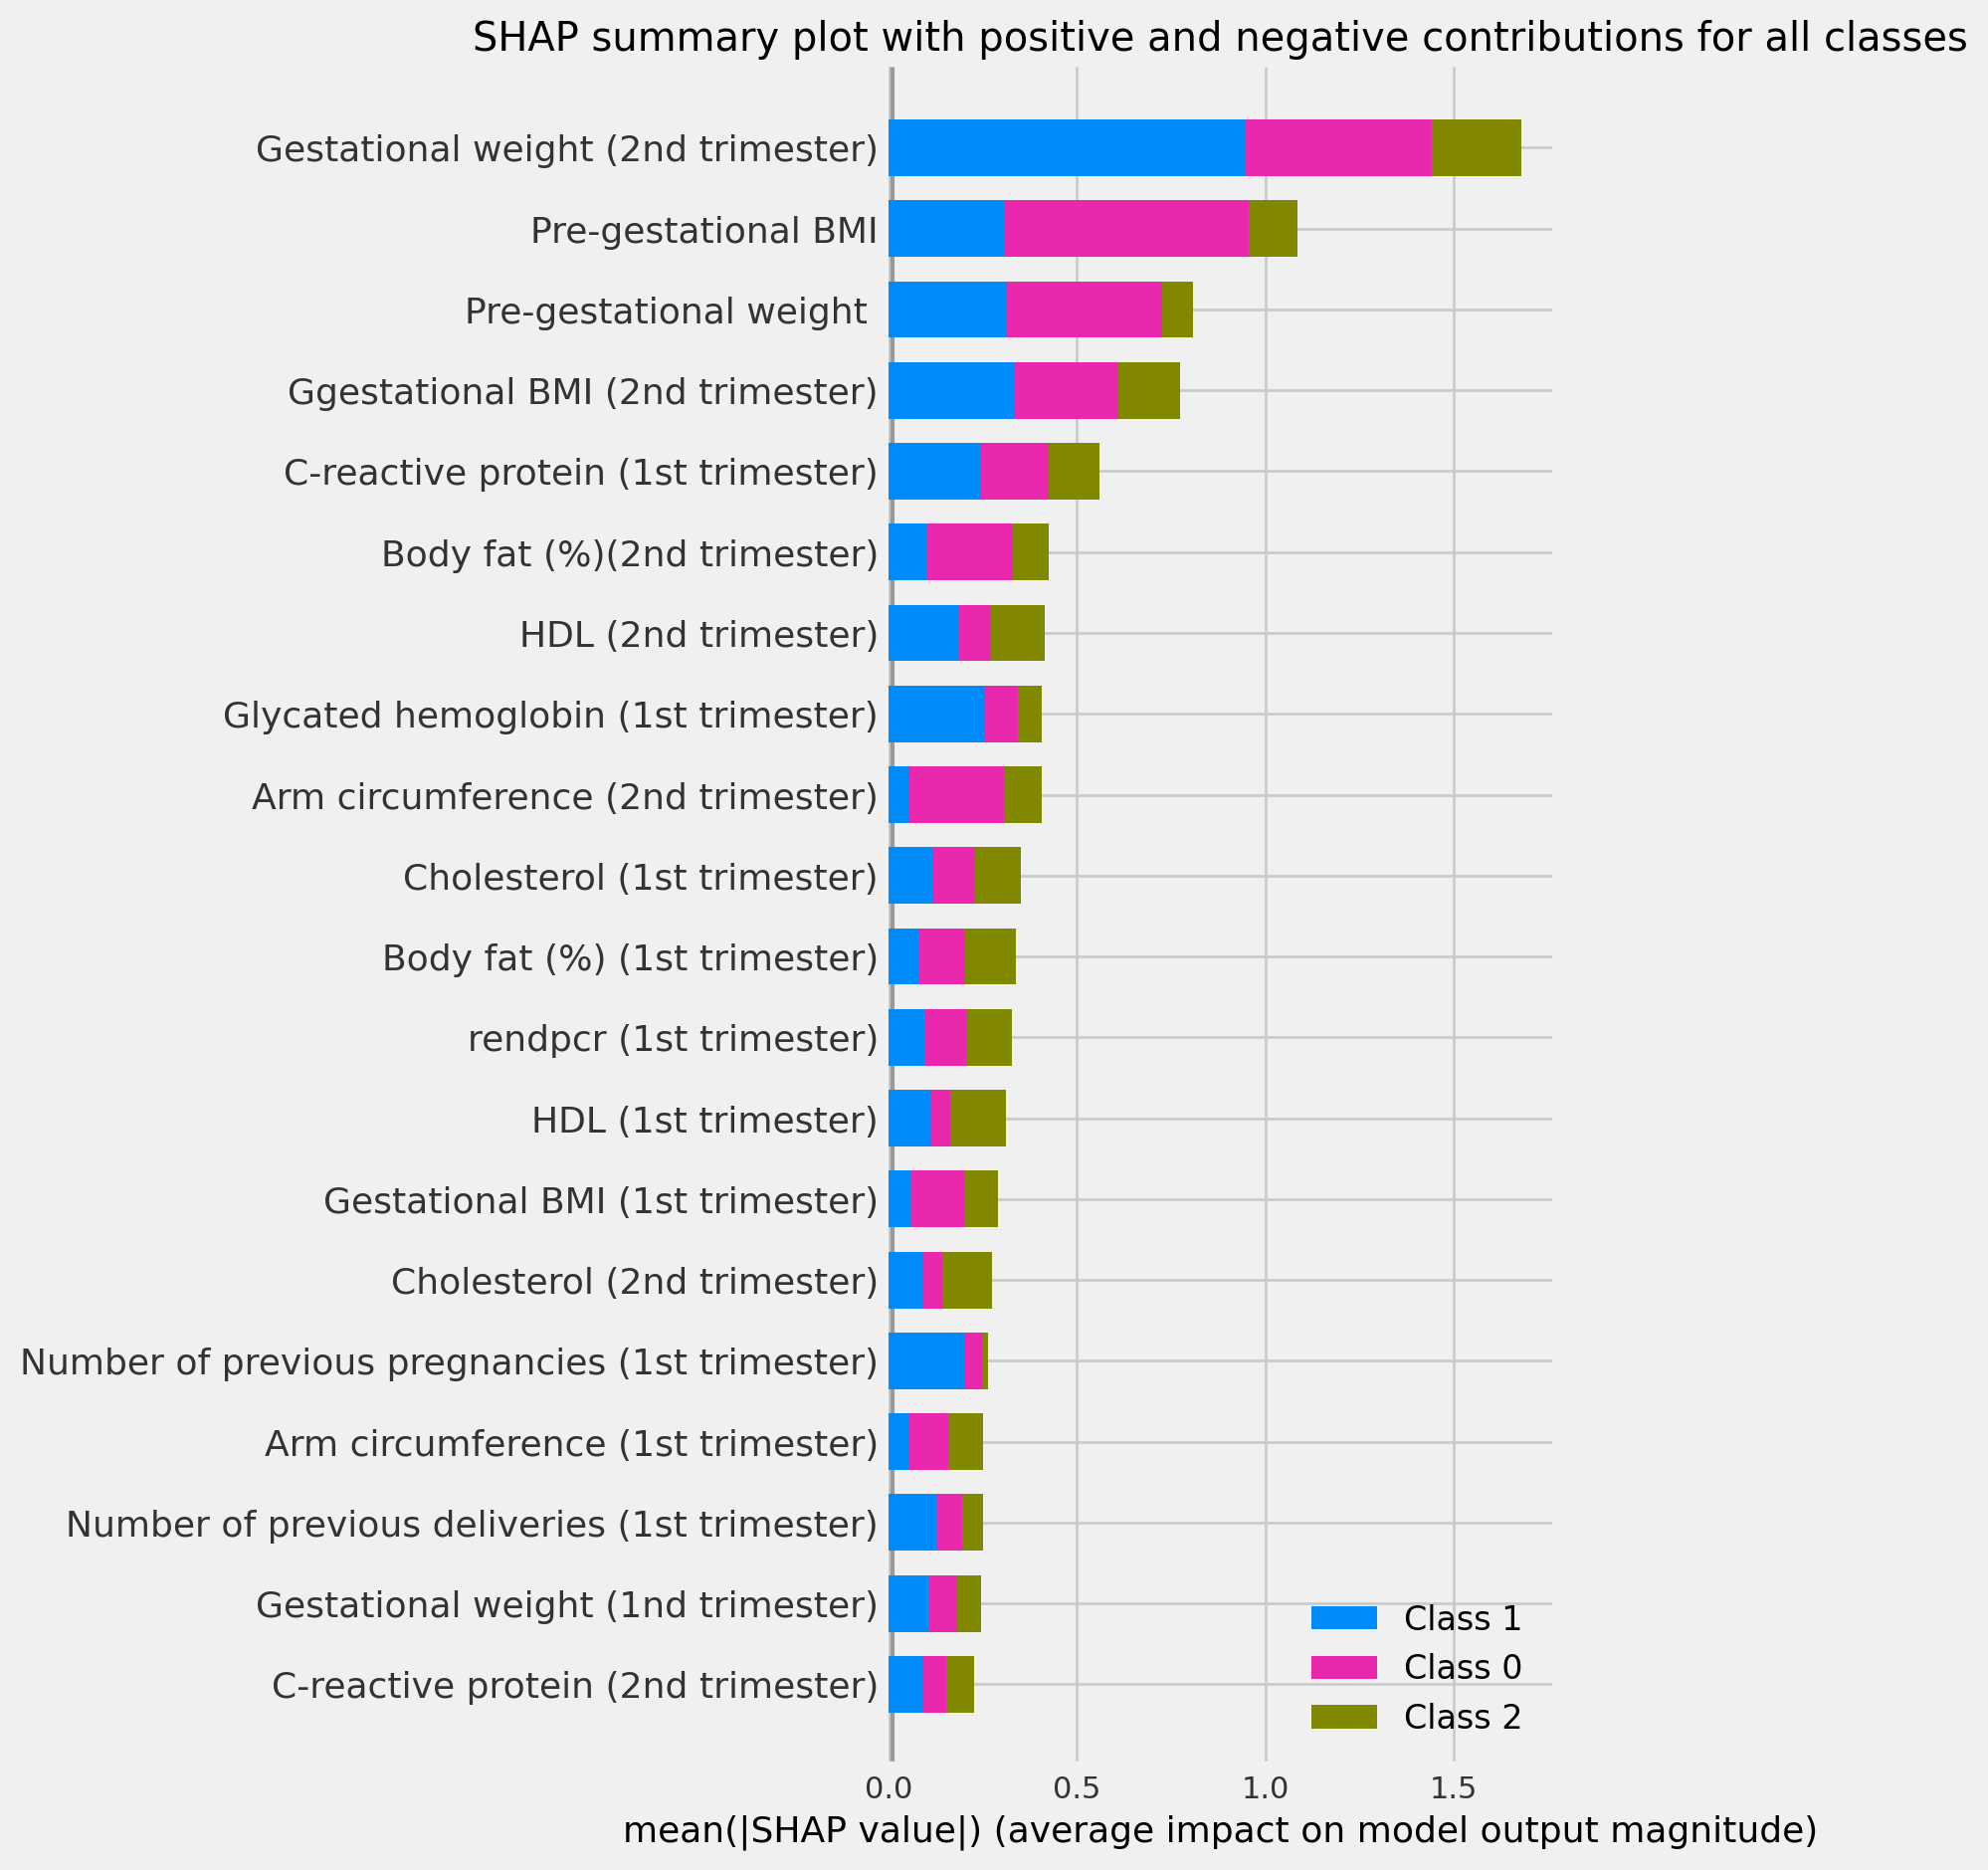

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
# Aplicar o mapeamento ao gráfico SHAP
feature_names = [feature_mapping.get(col, col) for col in X_test.columns]
shap_values = shap.TreeExplainer(best_model).shap_values(X_test)
# shap.summary_plot(shap_values, X_test)
# Plotando os valores SHAP com os nomes de características personalizados
plt.figure(figsize=(10, 8))
plt.title('SHAP summary plot with positive and negative contributions for all classes')
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
plt.show()
plt.savefig('shap_multilabel.jpg')

In [ ]:
# # Calcular e plotar valores Shapley para cada modelo
# for model_name, model in models:
#     if model_name == 'Logistic Regression':
#         explainer = shap.LinearExplainer(model, X_train)
#         shap_values = explainer.shap_values(X_test)
#         shap_values = shap_values if isinstance(shap_values, list) else [shap_values]
#     else:
#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer.shap_values(X_test)

#     print(f'Plotando valores Shapley para {model_name}')

#     # Gráfico de resumo das importâncias das características
#     shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns